# Report

## Introduction and data

> REMOVE THE FOLLOWING TEXT

This section includes an introduction to the project motivation, data, and research question.
Describe the data and definitions of key variables.

It should also include some exploratory data analysis.

All of the EDA won't fit in the paper, so focus on the EDA for the response variable and a few other interesting variables and relationships.

Der Profifußball ist nicht nur eine der weltweit populärsten Sportarten, sondern auch ein komplexes globales Wirtschaftsphänomen. Spielertransfers und die damit verbundenen Marktwerte von Profifußballern stellen zentrale Elemente dar, die sowohl für Vereine als auch für Investoren von entscheidender Bedeutung sind. Die Frage, wie der Marktwert eines Spielers bestimmt wird und welche Faktoren darauf einwirken, ist sowohl für die Sportökonomie als auch für datenwissenschaftliche Forschungen von großem Interesse.
Die Bewertung von Spielerleistungen und das Ermitteln ihrer finanziellen Wertigkeit ist jedoch keine triviale Aufgabe. Sie umfasst zahlreiche Variablen, darunter individuelle Leistungsdaten, Alter, Position, Verletzungshistorie, internationale Erfahrung sowie die Dynamik des Transfermarktes. 
Das Ziel dieses Projekts ist es, die zentralen Faktoren zu identifizieren, die den Marktwert eines Spielers beeinflussen, und ein Modell zu entwickeln, das auf Basis dieser Erkenntnisse Marktwerte mit hoher Genauigkeit vorhersagen kann. Hierbei kommen historische Daten, statistische Analysen und moderne Verfahren des maschinellen Lernens zum Einsatz

Wissenschaftliche Relevanz

Die Erforschung von Marktwertvorhersagen im Profifußball verbindet wissenschaftliche Disziplinen wie Statistik, Ökonomie, Informatik und Sportwissenschaft. Neben der Verbesserung von Entscheidungsprozessen für Vereine und Scouts bietet diese Arbeit auch wertvolle Erkenntnisse über die Mechanismen und Dynamiken eines der lukrativsten Sportmärkte der Welt.

Hypothese: Der Marktwert eines Profifußballspielers kann mithilfe eines Baumdiagramm vorhergesagt werden, wenn Variablen wie individuelle Leistungsdaten, physische Eigenschaften, Alter, Markttrends und Transferhistorien systematisch analysiert und in ein maschinelles Lernmodell integriert werden.


### Setup

In [214]:
import re
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import plotly.express as px
import plotly.io as pio

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
#import vegafusion as vf

In [215]:
pd.set_option('display.max_columns', None) 

### Import data

In [216]:
appearances = pd.read_parquet("../data/raw/appearances.parquet")
player_valuations = pd.read_parquet("../data/raw/player_valuations.parquet")
transfers = pd.read_parquet("../data/raw/transfers.parquet")
players = pd.read_parquet("../data/raw/players.parquet")

### Data structure

In [217]:
print("Appearances columns: \n", appearances.columns)
print("\n Player Valuations columns: \n", player_valuations.columns)
print("\n Transfers columns: \n", transfers.columns)
print("\n Players columns: \n", players.columns)

Appearances columns: 
 Index(['appearance_id', 'game_id', 'player_id', 'player_club_id',
       'player_current_club_id', 'date', 'player_name', 'competition_id',
       'yellow_cards', 'red_cards', 'goals', 'assists', 'minutes_played'],
      dtype='object')

 Player Valuations columns: 
 Index(['player_id', 'date', 'market_value_in_eur', 'current_club_id',
       'player_club_domestic_competition_id'],
      dtype='object')

 Transfers columns: 
 Index(['player_id', 'transfer_date', 'transfer_season', 'from_club_id',
       'to_club_id', 'from_club_name', 'to_club_name', 'transfer_fee',
       'market_value_in_eur', 'player_name'],
      dtype='object')

 Players columns: 
 Index(['player_id', 'first_name', 'last_name', 'name', 'last_season',
       'current_club_id', 'player_code', 'country_of_birth', 'city_of_birth',
       'country_of_citizenship', 'date_of_birth', 'sub_position', 'position',
       'foot', 'height_in_cm', 'contract_expiration_date', 'agent_name',
       'image_ur

#### Appearances DataFrame
 **Beschreibung:** Diese Tabelle enthält historische Daten über die Leistungen eines Spielers in einzelnen Spielen.
 **Wichtige Spalten:**
 - `player_id`: Eindeutige Spieler-ID.
 - `date`: Datum des Spiels.
 - `player_name`: Name des Spielers.
 - `competition_id`: ID des Wettbewerbs.
 - `yellow_cards`, `red_cards`: Anzahl gelber und roter Karten.
 - `goals`, `assists`: Tore und Vorlagen im Spiel.
 - `minutes_played`: Anzahl der gespielten Minuten.

In [218]:
appearances.head(2)

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
0,2231978_38004,2231978,38004,853,235,2012-07-03,Aurélien Joachim,CLQ,0,0,2,0,90
1,2233748_79232,2233748,79232,8841,2698,2012-07-05,Ruslan Abyshov,ELQ,0,0,0,0,90


#### Player Valuations DataFrame
 **Beschreibung:** Diese Tabelle zeigt die Marktwertentwicklungen der Spieler über die Zeit.
 **Wichtige Spalten:**
 - `player_id`: Eindeutige Spieler-ID.
 - `date`: Datum der Marktwertermittlung.
 - `market_value_in_eur`: Erster Marktwert in Euro.
 - `current_club_id`: ID des aktuellen Clubs.
 - `player_club_domestic_competition_id`: ID des nationalen Wettbewerbs des aktuellen Clubs.


In [219]:
player_valuations.head(2)

,player_id,date,market_value_in_eur,current_club_id,player_club_domestic_competition_id
0,405973,2000-01-20,150000,3057,BE1
1,342216,2001-07-20,100000,1241,SC1


#### Transfers DataFrame
 **Beschreibung:** Diese Tabelle enthält Informationen zu Spielertransfers zwischen Clubs.
 **Wichtige Spalten:**
 - `player_id`: Eindeutige Spieler-ID.
 - `transfer_date`: Datum des Transfers.
 - `transfer_season`: Saison des Transfers.
 - `from_club_id`, `to_club_id`: IDs des abgebenden und aufnehmenden Clubs.
 - `from_club_name`, `to_club_name`: Namen der Clubs.
 - `transfer_fee`: Transfergebühr in Euro.
 - `market_value_in_eur`: Marktwert des Spielers zum Zeitpunkt des Transfers.

In [220]:
transfers.head(2)

,player_id,transfer_date,transfer_season,from_club_id,to_club_id,from_club_name,to_club_name,transfer_fee,market_value_in_eur,player_name
0,195778,2026-06-30,25/26,79,27,VfB Stuttgart,Bayern Munich,0.0,12000000.0,Alexander Nübel
1,569033,2026-06-30,25/26,39,27,1.FSV Mainz 05,Bayern Munich,0.0,4000000.0,Armindo Sieb


#### Players DataFrame
 **Beschreibung:** Diese Tabelle enthält Basisinformationen zu Spielern.
 **Wichtige Spalten:**
 - `player_id`: Eindeutige Spieler-ID.
 - `name`, `first_name`, `last_name`: Name des Spielers.
 - `country_of_birth`, `country_of_citizenship`: Geburtsland und Staatsangehörigkeit.
 - `foot`: Bevorzugter Fuß (rechts/links).
 - `height_in_cm`: Körpergröße in cm.
 - `contract_expiration_date`: Vertragslaufzeitende.
 - `current_club_name`: Name des aktuellen Clubs.
 - `market_value_in_eur`: Aktueller Marktwert in Euro.
 - `highest_market_value_in_eur`: Höchster Marktwert in Euro.

In [221]:
players.head(2)

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur
0,10,Miroslav,Klose,Miroslav Klose,2015,398,miroslav-klose,Poland,Opole,Germany,1978-06-09 00:00:00,Centre-Forward,Attack,right,184.0,None,ASBW Sport Marketing,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/miroslav-klose...,IT1,Società Sportiva Lazio S.p.A.,1000000.0,30000000.0
1,26,Roman,Weidenfeller,Roman Weidenfeller,2017,16,roman-weidenfeller,Germany,Diez,Germany,1980-08-06 00:00:00,Goalkeeper,Goalkeeper,left,190.0,None,Neubauer 13 GmbH,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/roman-weidenfe...,L1,Borussia Dortmund,750000.0,8000000.0


### Data corrections

#### Aggregierte Appearances DataFrame
- **Beschreibung:** Diese Tabelle fasst die Leistungen eines Spielers über alle Spiele zusammen.
- **Aggregierte Spalten:**
  - `total_minutes_played`: Gesamte Spielminuten.
  - `total_goals`, `total_assists`: Gesamte Tore und Vorlagen.
  - `total_yellow_cards`, `total_red_cards`: Summe der gelben und roten Karten.
  - `total_golas_per_game`: Totaler Durchschnitt der Tore pro Spiel 


In [222]:
appearances_agg = appearances.groupby('player_id').agg({
    'minutes_played': 'sum',  # Gesamtminuten
    'goals': 'sum',           # Gesamttore
    'assists': 'sum',         # Gesamtvorlagen
    'yellow_cards': 'sum',    # Gelbe Karten
    'red_cards': 'sum',       # Rote Karten
    'game_id': 'count'        # Anzahl der Spiele
}).reset_index()

appearances_agg.rename(columns={
    'minutes_played': 'total_minutes_played',
    'goals': 'total_goals',
    'assists': 'total_assists',
    'yellow_cards': 'total_yellow_cards',
    'red_cards': 'total_red_cards',
    'game_id': 'total_matches'
}, inplace=True)


appearances_agg.head()

,player_id,total_minutes_played,total_goals,total_assists,total_yellow_cards,total_red_cards,total_matches
0,10,8808,48,25,19,0,136
1,26,13508,0,0,4,2,152
2,65,8788,38,13,11,1,122
3,77,307,0,0,0,0,4
4,80,1080,0,0,0,0,12


#### Aggregierte Appearancespro Jahr (historisiert)
- **Beschreibung:** Diese Tabelle fasst die Leistung jährlich eines Spielers über alle Spiele zusammen.
- **Aggregierte Spalten:**
  - `minutes_played_per_game`: Gesamte Spielminuten.
  - `assists_per_game`: Gesamte Vorlagen.
  - `yellow_cards_per_game`, `red_cards_per_game`: Summe der gelben und roten Karten.
  - `golas_per_game`: Totaler Durchschnitt der Tore pro Spiel 


In [223]:
appearances['date'] = pd.to_datetime(appearances['date'])
appearances['year'] = appearances['date'].dt.year

appearances_hist = appearances.groupby(['player_id', 'year']).agg({
    'minutes_played': 'sum',
    'goals': 'sum',         
    'assists': 'sum',       
    'yellow_cards': 'sum',  
    'red_cards': 'sum',     
    'game_id': 'count' 
}).reset_index()

appearances_hist['goals_per_game'] = appearances_hist['goals'] / appearances_hist['game_id']
appearances_hist['assists_per_game'] = appearances_hist['assists'] / appearances_hist['game_id']
appearances_hist['yellow_cards_per_game'] = appearances_hist['yellow_cards'] / appearances_hist['game_id']
appearances_hist['red_cards_per_game'] = appearances_hist['red_cards'] / appearances_hist['game_id']
appearances_hist['minutes_played_per_game'] = appearances_hist['minutes_played'] / appearances_hist['game_id']

appearances_hist.drop(["minutes_played", "goals", "assists", "yellow_cards", "red_cards", "game_id"], axis=1, inplace =True)

appearances_hist.head()

,player_id,year,goals_per_game,assists_per_game,yellow_cards_per_game,red_cards_per_game,minutes_played_per_game
0,10,2012,0.550000,0.050000,0.300000,0.0,74.150000
1,10,2013,0.310345,0.137931,0.103448,0.0,70.758621
2,10,2014,0.258065,0.193548,0.096774,0.0,56.967742
3,10,2015,0.333333,0.222222,0.166667,0.0,67.472222
4,10,2016,0.400000,0.300000,0.050000,0.0,53.900000


In diesem Schritt werden die Leistungsdaten der Spieler, wie Tore, Assists und Karten, auf Spielebene normalisiert, um Metriken wie `goals_per_game` oder `assists_per_game` zu berechnen. Dadurch wird die Leistung unabhängig von der Anzahl absolvierter Spiele dargestellt, was eine objektivere Analyse ermöglicht und zeitliche Entwicklungen präziser abbildet. Dies erlaubt eine differenziertere Analyse, die weniger von der Anzahl der absolvierten Spiele beeinflusst ist.

In [224]:
player_data = appearances_hist[appearances_hist['player_id'] == 342229]
fig = px.line(
    player_data,
    x='year',
    y='goals_per_game',
    title='Tore pro Spiel im Zeitverlauf',
    labels={'goals_per_game': 'Tore pro Spiel', 'year': 'Jahr'}
)
fig.update_layout(
    xaxis=dict(
        tickmode='linear',
        tick0=min(player_data['year']),
        dtick=1  # Schritte von 1 Jahr
    )
)
#speichern
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

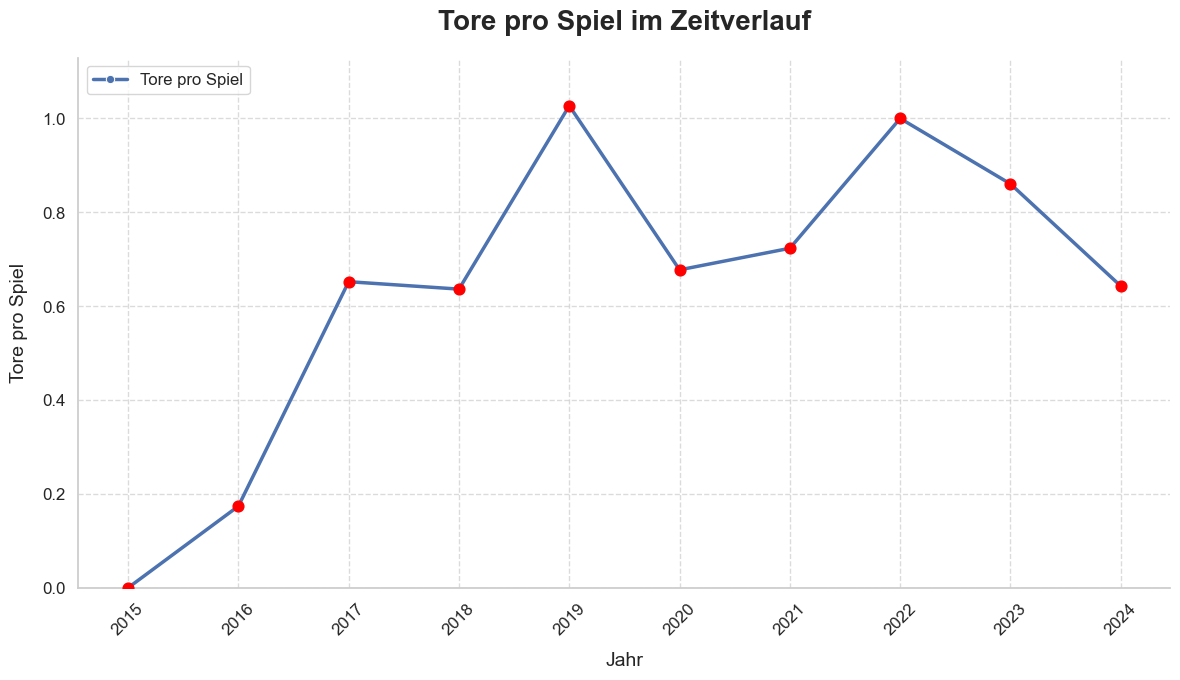

In [225]:
sns.set_style("whitegrid")
sns.set_palette("deep")

player_data = appearances_hist[appearances_hist['player_id'] == 342229]

plt.figure(figsize=(12, 7))

sns.lineplot(data=player_data, x='year', y='goals_per_game', linewidth=2.5, marker='o')
plt.scatter(player_data['year'], player_data['goals_per_game'], s=60, color='red', zorder=5)

plt.title('Tore pro Spiel im Zeitverlauf', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Jahr', fontsize=14, labelpad=10)
plt.ylabel('Tore pro Spiel', fontsize=14, labelpad=10)

plt.xticks(range(min(player_data['year']), max(player_data['year'])+1, 1), rotation=45)
plt.ylim(0, max(player_data['goals_per_game']) * 1.1)
plt.grid(True, linestyle='--', alpha=0.7)
sns.despine()
plt.legend(['Tore pro Spiel'], loc='upper left', fontsize=12)

plt.tight_layout()
plt.show()



#### Fehldende Werte raussuchen und Daten Engineering

In [226]:
print("Fehlende Werte in appearances:")
print(appearances.isnull().sum())

Fehlende Werte in appearances:
appearance_id             0
game_id                   0
player_id                 0
player_club_id            0
player_current_club_id    0
date                      0
player_name               6
competition_id            0
yellow_cards              0
red_cards                 0
goals                     0
assists                   0
minutes_played            0
year                      0
dtype: int64


In [227]:
print("Fehlende Werte in player_valuations:")
player_valuations['date'] = pd.to_datetime(player_valuations['date'])
player_valuations['year'] = player_valuations['date'].dt.year

#player_valuations.drop("date", axis=1, inplace=True) # date wird gelöscht um auf Jahreseben den Marktwert zu untersuchen
player_valuations = player_valuations.drop_duplicates(subset=['player_id','year'], keep='last') # damit wird gewährleistet, dass pro Jahr auf nur ein Marktwert pro Spieler limitiert wird
print(player_valuations.isnull().sum())

Fehlende Werte in player_valuations:
player_id                              0
date                                   0
market_value_in_eur                    0
current_club_id                        0
player_club_domestic_competition_id    0
year                                   0
dtype: int64


Durch `drop_duplicates(subset=['player_id','year'], keep='last')` wird gewährleistet, dass es auf nur ein Marktwert pro Spieler im Jahr limitiert wird. Da es Spieler gibt deren Marktwert mehrmals im Jahr abgefragt wird.

In [228]:
print("Fehlende Werte in transfers:")
transfers['transfer_date'] = pd.to_datetime(transfers['transfer_date'])
transfers['year'] = transfers['transfer_date'].dt.year
# wichtig für das Mergen später
print(transfers.isnull().sum())

Fehlende Werte in transfers:
player_id                  0
transfer_date              0
transfer_season            0
from_club_id               0
to_club_id                 0
from_club_name             0
to_club_name               0
transfer_fee           27262
market_value_in_eur    29783
player_name                0
year                       0
dtype: int64


In [229]:
print("Fehlende Werte in players:")

print(players.isnull().sum())

Fehlende Werte in players:
player_id                                   0
first_name                               2060
last_name                                   0
name                                        0
last_season                                 0
current_club_id                             0
player_code                                 0
country_of_birth                         2804
city_of_birth                            2464
country_of_citizenship                    380
date_of_birth                              47
sub_position                              183
position                                    0
foot                                     2568
height_in_cm                             2303
contract_expiration_date                12111
agent_name                              15986
image_url                                   0
url                                         0
current_club_domestic_competition_id        0
current_club_name                           0
market_

In [230]:
players.dropna(subset=['market_value_in_eur'], inplace=True)

In [231]:
print("Fehlende Werte in appearances_hist:")
print(appearances_hist.isnull().sum())

Fehlende Werte in appearances_hist:
player_id                  0
year                       0
goals_per_game             0
assists_per_game           0
yellow_cards_per_game      0
red_cards_per_game         0
minutes_played_per_game    0
dtype: int64


#### Merging Datasets

`combined_data_agg` enthält die aggregierte Version (`appearances_agg`) der Spieler. Keine Historie enthalten durch `drop_duplicates(subset='player_id', keep='last')` wird der aktuellste Marktewert genommen.

In [232]:
combined_data_agg = players.merge(appearances_agg, on='player_id', how='inner')

#combined_data_agg = combined_data_agg.merge(transfers[['player_id', 'transfer_fee', 'market_value_in_eur','year']].drop_duplicates(subset='player_id', keep='first'), 
#                                    on=['player_id'], how='left')

combined_data_agg.head()

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur,total_minutes_played,total_goals,total_assists,total_yellow_cards,total_red_cards,total_matches
0,10,Miroslav,Klose,Miroslav Klose,2015,398,miroslav-klose,Poland,Opole,Germany,1978-06-09 00:00:00,Centre-Forward,Attack,right,184.0,None,ASBW Sport Marketing,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/miroslav-klose...,IT1,Società Sportiva Lazio S.p.A.,1000000.0,30000000.0,8808,48,25,19,0,136
1,26,Roman,Weidenfeller,Roman Weidenfeller,2017,16,roman-weidenfeller,Germany,Diez,Germany,1980-08-06 00:00:00,Goalkeeper,Goalkeeper,left,190.0,None,Neubauer 13 GmbH,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/roman-weidenfe...,L1,Borussia Dortmund,750000.0,8000000.0,13508,0,0,4,2,152
2,65,Dimitar,Berbatov,Dimitar Berbatov,2015,1091,dimitar-berbatov,Bulgaria,Blagoevgrad,Bulgaria,1981-01-30 00:00:00,Centre-Forward,Attack,None,NaN,None,CSKA-AS-23 Ltd.,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/dimitar-berbat...,GR1,Panthessalonikios Athlitikos Omilos Konstantin...,1000000.0,34500000.0,8788,38,13,11,1,122
3,77,None,Lúcio,Lúcio,2012,506,lucio,Brazil,Brasília,Brazil,1978-05-08 00:00:00,Centre-Back,Defender,None,NaN,None,None,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/lucio/profil/s...,IT1,Juventus Football Club,200000.0,24500000.0,307,0,0,0,0,4
4,80,Tom,Starke,Tom Starke,2017,27,tom-starke,East Germany (GDR),Freital,Germany,1981-03-18 00:00:00,Goalkeeper,Goalkeeper,right,194.0,None,IFM,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/tom-starke/pro...,L1,FC Bayern München,100000.0,3000000.0,1080,0,0,0,0,12


In [233]:
combined_data_agg[combined_data_agg["name"]=="Kylian Mbappé"]

,player_id,first_name,last_name,name,last_season,current_club_id,player_code,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur,highest_market_value_in_eur,total_minutes_played,total_goals,total_assists,total_yellow_cards,total_red_cards,total_matches
16243,342229,Kylian,Mbappé,Kylian Mbappé,2024,418,kylian-mbappe,France,Paris,France,1998-12-20 00:00:00,Centre-Forward,Attack,right,178.0,2029-06-30 00:00:00,None,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/kylian-mbappe/...,ES1,Real Madrid Club de Fútbol,180000000.0,200000000.0,26230,253,103,45,1,346


`combined_data_hist` enthält die historisierte Version (`appearances_hist`) der Aggregationen 

In [234]:
combined_data_hist = player_valuations.merge(players, on='player_id', how='inner')
combined_data_hist = combined_data_hist.merge(appearances_hist, on=['player_id', 'year'], how='inner')

combined_data_hist = combined_data_hist.merge(transfers[['player_id', 'transfer_fee', 'market_value_in_eur', 'year', 'transfer_season']], 
                                    on=['player_id', 'year'] , how='left')

combined_data_hist.head()

,player_id,date,market_value_in_eur_x,current_club_id_x,player_club_domestic_competition_id,year,first_name,last_name,name,last_season,current_club_id_y,player_code,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,contract_expiration_date,agent_name,image_url,url,current_club_domestic_competition_id,current_club_name,market_value_in_eur_y,highest_market_value_in_eur,goals_per_game,assists_per_game,yellow_cards_per_game,red_cards_per_game,minutes_played_per_game,transfer_fee,market_value_in_eur,transfer_season
0,21552,2012-01-01,250000,383,NL1,2012,Danny,Wintjens,Danny Wintjens,2014,383,danny-wintjens,Netherlands,Maastricht,Netherlands,1983-09-30 00:00:00,Goalkeeper,Goalkeeper,right,195.0,None,None,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/danny-wintjens...,NL1,Eindhovense Voetbalvereniging Philips Sport Ve...,150000.0,450000.0,0.000000,0.000000,0.000000,0.0,89.800000,NaN,NaN,NaN
1,34556,2012-01-01,500000,1426,NL1,2012,Arjan,Swinkels,Arjan Swinkels,2020,1426,arjan-swinkels,Netherlands,Moergestel,Netherlands,1984-10-15 00:00:00,Centre-Back,Defender,left,184.0,None,None,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/arjan-swinkels...,NL1,VVV-Venlo,125000.0,700000.0,0.000000,0.000000,0.000000,0.0,90.000000,NaN,NaN,NaN
2,41583,2012-01-01,250000,1269,NL1,2012,Bram,van Polen,Bram van Polen,2023,1269,bram-van-polen,Netherlands,Nijkerk,Netherlands,1985-10-11 00:00:00,Right-Back,Defender,right,179.0,None,None,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/bram-van-polen...,NL1,Prins Hendrik Ende Desespereert Nimmer Combina...,100000.0,1000000.0,0.000000,0.050000,0.250000,0.0,91.500000,NaN,NaN,NaN
3,56438,2012-01-01,150000,403,NL1,2012,Ruud,van der Rijt,Ruud van der Rijt,2012,403,ruud-van-der-rijt,Netherlands,Nijnsel,Netherlands,1988-11-17 00:00:00,Centre-Back,Defender,right,185.0,None,None,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/ruud-van-der-r...,NL1,Willem II,200000.0,200000.0,0.000000,0.000000,0.400000,0.0,85.600000,NaN,NaN,NaN
4,83946,2012-01-01,250000,1268,NL1,2012,Youness,Mokhtar,Youness Mokhtar,2020,1268,youness-mokhtar,Netherlands,Utrecht,Morocco,1991-08-29 00:00:00,Left Winger,Attack,right,178.0,2023-06-30 00:00:00,None,https://img.a.transfermarkt.technology/portrai...,https://www.transfermarkt.co.uk/youness-mokhta...,NL1,ADO Den Haag,300000.0,2500000.0,0.263158,0.052632,0.052632,0.0,81.315789,NaN,NaN,NaN


#### Feature Engineering

In [235]:
combined_data_hist.rename(columns={
    'market_value_in_eur_x': 'historical_to_date__market_value',
    'market_value_in_eur_y': 'current_market_value',
    'market_value_in_eur': 'transfer_market_value',
    'player_club_domestic_competition_id': 'league_id'
}, inplace=True)

combined_data_agg.rename(columns={
    'market_value_in_eur': 'current_market_value',
    'current_club_domestic_competition_id': 'league_id'
}, inplace=True)

In [236]:
## Feautre Engineering: transfer gap
combined_data_hist['transfer_fee_gap'] = combined_data_hist['transfer_fee'] - combined_data_hist['transfer_market_value']
combined_data_hist.drop(columns=['current_club_id_x', 'current_club_id_y', 'image_url', 'url', 'agent_name', 'player_code', 'first_name', 'last_name', 'current_club_domestic_competition_id'], inplace=True)

In [237]:
combined_data_agg.drop(columns=['image_url', 'url', 'agent_name', 'player_code', 'first_name', 'last_name'], inplace=True)

`transfer_fee_gap` enthält die Differenz zwischen der Transfer Gebühr und den jeweiligen Marktwert im Jahr des Transfers. Da die Transfers jährlich vorliegen, werden der `transfer_fee_gap` nur bei der historischen Version hinzugefügt 

##### Alter ergänzen und evaluieren

In [238]:
## Feautre Engineering: Alter
combined_data_hist['age'] = (pd.to_datetime(combined_data_hist['date']).dt.year - 
                         pd.to_datetime(combined_data_hist['date_of_birth']).dt.year)

current_year = datetime.now().year
combined_data_agg['age'] = current_year - pd.to_datetime(combined_data_agg['date_of_birth']).dt.year


In [239]:
combined_data_hist[['date_of_birth', 'age']].head()

,date_of_birth,age
0,1983-09-30 00:00:00,29.0
1,1984-10-15 00:00:00,28.0
2,1985-10-11 00:00:00,27.0
3,1988-11-17 00:00:00,24.0
4,1991-08-29 00:00:00,21.0


In [240]:
combined_data_agg.head(2)

,player_id,name,last_season,current_club_id,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,contract_expiration_date,league_id,current_club_name,current_market_value,highest_market_value_in_eur,total_minutes_played,total_goals,total_assists,total_yellow_cards,total_red_cards,total_matches,age
0,10,Miroslav Klose,2015,398,Poland,Opole,Germany,1978-06-09 00:00:00,Centre-Forward,Attack,right,184.0,None,IT1,Società Sportiva Lazio S.p.A.,1000000.0,30000000.0,8808,48,25,19,0,136,47.0
1,26,Roman Weidenfeller,2017,16,Germany,Diez,Germany,1980-08-06 00:00:00,Goalkeeper,Goalkeeper,left,190.0,None,L1,Borussia Dortmund,750000.0,8000000.0,13508,0,0,4,2,152,45.0


In [241]:
combined_data_hist.head(2)

,player_id,date,historical_to_date__market_value,league_id,year,name,last_season,country_of_birth,city_of_birth,country_of_citizenship,date_of_birth,sub_position,position,foot,height_in_cm,contract_expiration_date,current_club_name,current_market_value,highest_market_value_in_eur,goals_per_game,assists_per_game,yellow_cards_per_game,red_cards_per_game,minutes_played_per_game,transfer_fee,transfer_market_value,transfer_season,transfer_fee_gap,age
0,21552,2012-01-01,250000,NL1,2012,Danny Wintjens,2014,Netherlands,Maastricht,Netherlands,1983-09-30 00:00:00,Goalkeeper,Goalkeeper,right,195.0,None,Eindhovense Voetbalvereniging Philips Sport Ve...,150000.0,450000.0,0.0,0.0,0.0,0.0,89.8,NaN,NaN,NaN,NaN,29.0
1,34556,2012-01-01,500000,NL1,2012,Arjan Swinkels,2020,Netherlands,Moergestel,Netherlands,1984-10-15 00:00:00,Centre-Back,Defender,left,184.0,None,VVV-Venlo,125000.0,700000.0,0.0,0.0,0.0,0.0,90.0,NaN,NaN,NaN,NaN,28.0


In [242]:
combined_data_hist = combined_data_hist[combined_data_hist['age'] > 15]
combined_data_agg = combined_data_agg[combined_data_agg['age'] > 15]

combined_data_hist.shape

(105063, 29)

In diesem Schritt wird das Alter der Spieler zum Zeitpunkt der Marktwertbewertung berechnet, indem das Datum der Bewertung (`date`) und das Geburtsdatum des Spielers (`date_of_birth`) herangezogen werden. Anschließend wird der Datensatz gefiltert, sodass nur Spieler berücksichtigt werden, die zum Zeitpunkt der Bewertung ein Mindestalter von 15 Jahren erreicht haben.

Das Mindestalter von 15 Jahren wird als Untergrenze definiert, da Marktwertbewertungen für Spieler, die jünger als 15 Jahre alt sind, in der Regel unplausibel und fehlerhaft erscheinen. Solche Datensätze können als Ausreißer betrachtet werden und die statistische Analyse sowie die Vorhersagemodelle erheblich verfälschen.

##### Aktive oder in Rente 

In [243]:
current_year = 2025

combined_data_hist['is_retired'] = combined_data_hist['last_season'] <= (current_year - 5)

combined_data_agg['is_retired'] = combined_data_agg['last_season'] <= (current_year - 5)

Die neue  Variable `is_retired` erlaubt es, aktive und inaktive Spieler getrennt zu betrachten, was Verzerrungen in den Modellen reduzieren kann.

#### Change Datatypes

In [244]:
combined_data_hist.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105063 entries, 0 to 105127
Data columns (total 30 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   player_id                         105063 non-null  int64         
 1   date                              105063 non-null  datetime64[ns]
 2   historical_to_date__market_value  105063 non-null  int64         
 3   league_id                         105063 non-null  object        
 4   year                              105063 non-null  int32         
 5   name                              105063 non-null  object        
 6   last_season                       105063 non-null  int64         
 7   country_of_birth                  101334 non-null  object        
 8   city_of_birth                     102672 non-null  object        
 9   country_of_citizenship            103701 non-null  object        
 10  date_of_birth                     105

In [245]:
# IDs zu Strings umwandeln
id_columns = [
    "player_id", "league_id"
]
combined_data_hist[id_columns] = combined_data_hist[id_columns].astype(str)

# Datumsangaben umwandeln
date_columns = ["date", "date_of_birth", "contract_expiration_date"]
for col in date_columns:
    combined_data_hist[col] = pd.to_datetime(combined_data_hist[col], errors='coerce')


print(combined_data_hist.info())


<class 'pandas.core.frame.DataFrame'>
Index: 105063 entries, 0 to 105127
Data columns (total 30 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   player_id                         105063 non-null  object        
 1   date                              105063 non-null  datetime64[ns]
 2   historical_to_date__market_value  105063 non-null  int64         
 3   league_id                         105063 non-null  object        
 4   year                              105063 non-null  int32         
 5   name                              105063 non-null  object        
 6   last_season                       105063 non-null  int64         
 7   country_of_birth                  101334 non-null  object        
 8   city_of_birth                     102672 non-null  object        
 9   country_of_citizenship            103701 non-null  object        
 10  date_of_birth                     105

In [246]:
combined_data_agg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25082 entries, 0 to 25101
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   player_id                    25082 non-null  int64  
 1   name                         25082 non-null  object 
 2   last_season                  25082 non-null  int64  
 3   current_club_id              25082 non-null  int64  
 4   country_of_birth             23760 non-null  object 
 5   city_of_birth                24037 non-null  object 
 6   country_of_citizenship       24790 non-null  object 
 7   date_of_birth                25082 non-null  object 
 8   sub_position                 25019 non-null  object 
 9   position                     25082 non-null  object 
 10  foot                         24041 non-null  object 
 11  height_in_cm                 24321 non-null  float64
 12  contract_expiration_date     16118 non-null  object 
 13  league_id            

In [247]:
# IDs zu Strings umwandeln
id_columns = [
    "player_id", "current_club_id", "league_id"
]
combined_data_agg[id_columns] = combined_data_agg[id_columns].astype(str)

# Datumsangaben umwandeln
date_columns = [ "date_of_birth", "contract_expiration_date"]
for col in date_columns:
    combined_data_agg[col] = pd.to_datetime(combined_data_agg[col], errors='coerce')


print(combined_data_agg.info())

<class 'pandas.core.frame.DataFrame'>
Index: 25082 entries, 0 to 25101
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   player_id                    25082 non-null  object        
 1   name                         25082 non-null  object        
 2   last_season                  25082 non-null  int64         
 3   current_club_id              25082 non-null  object        
 4   country_of_birth             23760 non-null  object        
 5   city_of_birth                24037 non-null  object        
 6   country_of_citizenship       24790 non-null  object        
 7   date_of_birth                25082 non-null  datetime64[ns]
 8   sub_position                 25019 non-null  object        
 9   position                     25082 non-null  object        
 10  foot                         24041 non-null  object        
 11  height_in_cm                 24321 non-null  f

In [248]:

# abspeichern in data/processed
combined_data_hist.to_parquet('../data/processed/combined_data_hist.parquet')
combined_data_agg.to_parquet('../data/processed/combined_data_agg.parquet')

### Analysis

Für die Analysen wird die aggregierte Version der Dataframes `combined_data_agg` genutzt, um das mehrfache Vorkommen von Spielern zu verhindern. 

In [ ]:
fig = px.box(
    combined_data_agg, 
    y="current_market_value", 
    color=combined_data_agg['is_retired'].map({True: 'Retired', False: 'Active'}),
    title="Boxplot of Current Market Value, Divided by Active or Retired (2020) Player",
    labels={"current_market_value": "Current Market Value (in M€)"},
    hover_data=["name", "age"] 
)

fig.update_layout(
    yaxis=dict(title="Current Market Value (in M€)", showgrid=True),
    xaxis=dict(showticklabels=False),
    title=dict(x=0.5)  # Titel zentrieren
)

#fig.show()
#speichern
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

/var/folders/df/9tj0fbwx73g3tg845tnm3j480000gn/T/ipykernel_79674/171269167.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




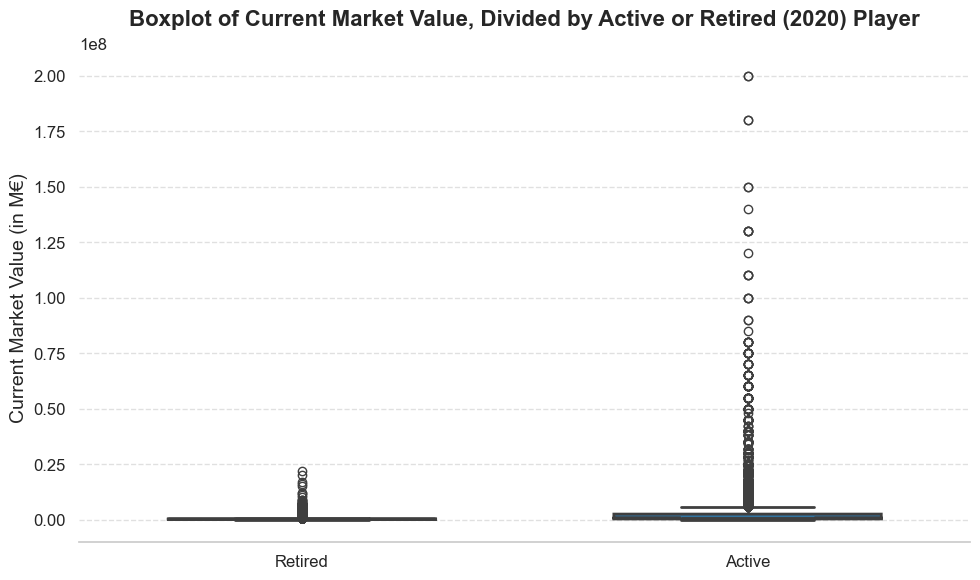

In [249]:
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=combined_data_agg,
    y="current_market_value",
    x=combined_data_agg['is_retired'].map({True: 'Retired', False: 'Active'}),
    palette={"Active": "#1f77b4", "Retired": "#d62728"},  # Blau für Active, Rot für Retired
    linewidth=2,
    width=0.6,
    notch=True
)

plt.title("Boxplot of Current Market Value, Divided by Active or Retired (2020) Player", fontsize=16, weight='bold', pad=20)
plt.ylabel("Current Market Value (in M€)", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine(left=True)

plt.tight_layout()
plt.show()

Die Boxplots zeigen die Verteilung der aktuellen Marktwerte von Fußballspielern, getrennt nach aktiven und pensionierten Spielern. Die Marktwerte konzentrieren sich überwiegend im unteren Bereich, wobei einige wenige aktive Spieler als Ausreißer deutlich höhere Werte aufweisen. Pensionierte Spieler haben insgesamt niedrigere Marktwerte und kaum Ausreißer, was auf eine homogenere Verteilung hinweist. Der Plot verdeutlicht die starke Schiefe der Marktwerte und die größere Streuung bei aktiven Spielern im Vergleich zu pensionierten.

#### Ohne Ausreißer

In [250]:
q1 = combined_data_agg["current_market_value"].quantile(0.25)
q3 = combined_data_agg["current_market_value"].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filtern der Daten ohne Ausreißer
combined_data_agg_no_outliers = combined_data_agg[
    (combined_data_agg["current_market_value"] >= lower_bound) & 
    (combined_data_agg["current_market_value"] <= upper_bound)
]

In [251]:
combined_data_agg_no_outliers.shape

(21546, 25)

In [252]:
fig = px.box(
    combined_data_agg_no_outliers, 
    y="current_market_value", 
    title="Boxplot of Current Market Value, Divided by Active or Retired (2020) Player, Without Outliers",
    labels={"current_market_value": "Current Market Value (in M€)"},
    hover_data=["name", "age"]
)

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

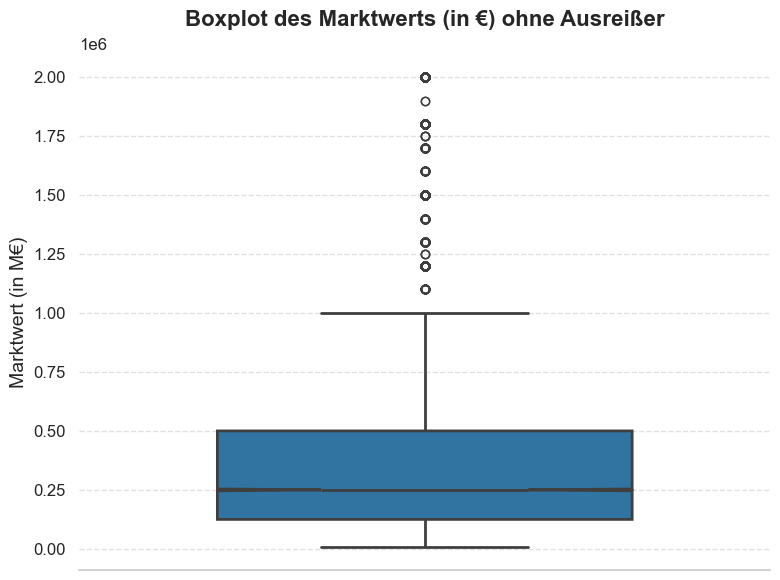

In [253]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    data=combined_data_agg_no_outliers,
    y="current_market_value",
    linewidth=2,
    width=0.6,
    color="#1f77b4",
    notch=True
)

plt.title("Boxplot des Marktwerts (in €) ohne Ausreißer", fontsize=16, weight='bold', pad=20)
plt.ylabel("Marktwert (in M€)", fontsize=14)
plt.xlabel("")
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine(left=True)

plt.tight_layout()
plt.show()

In [254]:
fig = px.box(
    combined_data_agg_no_outliers, 
    y="current_market_value", 
    color=combined_data_agg_no_outliers['is_retired'].map({True: 'Retired', False: 'Active'}),
    title="Boxplot of Current Market Value, Divided by Active or Retired (2020) Player, Without Outliers",
    labels={"current_market_value": "Current Market Value (in M€)"},
    hover_data=["name", "age"],
)

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

/var/folders/df/9tj0fbwx73g3tg845tnm3j480000gn/T/ipykernel_79674/1103429174.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




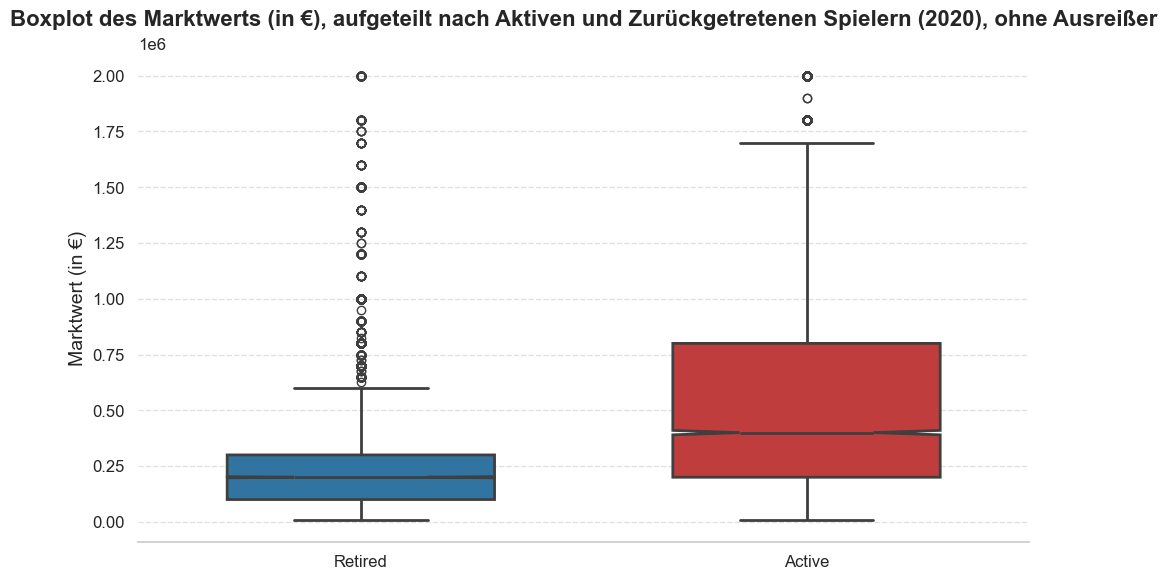

In [255]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=combined_data_agg_no_outliers,
    y="current_market_value",
    x=combined_data_agg_no_outliers['is_retired'].map({True: 'Retired', False: 'Active'}),
    palette={"Active": "#d62728", "Retired": "#1f77b4"},
    linewidth=2,
    width=0.6,
    notch=True
)

plt.title("Boxplot des Marktwerts (in €), aufgeteilt nach Aktiven und Zurückgetretenen Spielern (2020), ohne Ausreißer", fontsize=16, weight='bold', pad=20)
plt.ylabel("Marktwert (in €)", fontsize=14)
plt.xlabel("")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
sns.despine(left=True)

plt.tight_layout()
plt.show()

#### Descriptive statistics

In [256]:
#combined_data.describe().T

numeric_combined_data_agg = combined_data_agg.select_dtypes(include=["number"])
numeric_combined_data_agg.describe().T

,count,mean,std,min,25%,50%,75%,max
last_season,25082.0,2.019600e+03,3.976432e+00,2012.0,2016.00,2020.0,2023.0,2024.0
height_in_cm,24321.0,1.820993e+02,6.819914e+00,18.0,178.00,182.0,187.0,207.0
current_market_value,25082.0,1.950160e+06,7.013315e+06,10000.0,150000.00,300000.0,900000.0,200000000.0
highest_market_value_in_eur,25082.0,4.475840e+06,1.057416e+07,10000.0,400000.00,1000000.0,3500000.0,200000000.0
total_minutes_played,25082.0,4.565377e+03,6.303755e+03,1.0,363.25,1907.0,6276.0,49595.0
total_goals,25082.0,6.335460e+00,1.676031e+01,0.0,0.00,1.0,5.0,490.0
total_assists,25082.0,4.989674e+00,1.114626e+01,0.0,0.00,1.0,5.0,224.0
total_yellow_cards,25082.0,9.755761e+00,1.470991e+01,0.0,1.00,4.0,13.0,147.0
total_red_cards,25082.0,2.495415e-01,6.170342e-01,0.0,0.00,0.0,0.0,8.0
total_matches,25082.0,6.599793e+01,8.385051e+01,1.0,8.00,32.0,93.0,589.0


Die deskriptive Analyse zeigt eine große Vielfalt unter den Fußballspielern, sowohl in Bezug auf ihre Leistung als auch auf ihren Marktwert. Der durchschnittliche aktuelle Marktwert (`current_market_value`) liegt bei etwa 1,95 Millionen Euro, wobei die Werte von nur 10.000 Euro bis hin zu beeindruckenden 200 Millionen Euro reichen. Spieler haben im Durchschnitt 6,33 Tore (`total_goals`) und 4,99 Assists (`total_assists`) erzielt, mit maximalen Werten von 490 Toren und 224 Assists, was die Präsenz einiger außergewöhnlicher Akteure unterstreicht. Die durchschnittliche Anzahl absolvierter Spiele (`total_matches`) liegt bei rund 66, wobei einige Spieler bis zu 589 Spiele bestritten haben. Die durchschnittliche Spielzeit (`total_minutes_played`) beläuft sich auf 4.565 Minuten, mit einem Maximum von nahezu 50.000 Minuten. Disziplinarisch erhalten Spieler im Schnitt etwa 9,76 gelbe Karten (`total_yellow_cards`) und 0,25 rote Karten (`total_red_cards`) im Verlauf ihrer Karriere. Das durchschnittliche Alter der Spieler (`age`) beträgt 31 Jahre, mit einer Spannweite von 17 bis 55 Jahren, was sowohl die jungen Talente als auch erfahrene Veteranen repräsentiert.

#### Exploratory data analysis

Für EDA lieber historisierte Daten nutzen? Spieler kommen öfters vor durch historisierung

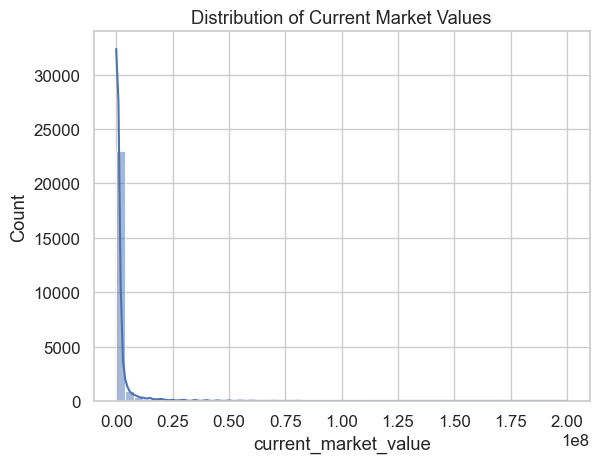

In [257]:
sns.histplot(combined_data_agg['current_market_value'], bins=50, kde=True)
plt.title("Distribution of Current Market Values")
plt.show()

auch bei agg gibt es welche die öfters vorkommen hier versuchen den neusten Datensatz zu nehmen

In [ ]:
lineplot_data = combined_data_hist[combined_data_hist['player_id'].isin(["418560", "371998", "342229"])]

fig = px.line(
    lineplot_data,
    x='year',
    y='historical_to_date__market_value',
    color='name',  # Unterschiedliche Spieler durch Farben darstellen
    line_group='player_id',
    hover_data={
        'name': True,
        'goals_per_game': True,  # Tore als zusätzliche Info
        'assists_per_game': True,  # Assists
        'year': True,    # Jahr
    },
    title="Vergleich der Marktwertentwicklung mehrerer Spieler",
    labels={
        'name': "Name",
        'year': 'Jahr',
        'goals_per_game': 'Tore pro Spiel',
        'assists_per_game':'Assist pro Spiel',
        'historical_to_date__market_value': 'Marktwert (in €)'
    }
)

fig.update_layout(
    xaxis_title="Jahr",
    yaxis_title="Marktwert (in €)",
    legend_title="Spieler",
    hovermode="x unified"
)

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

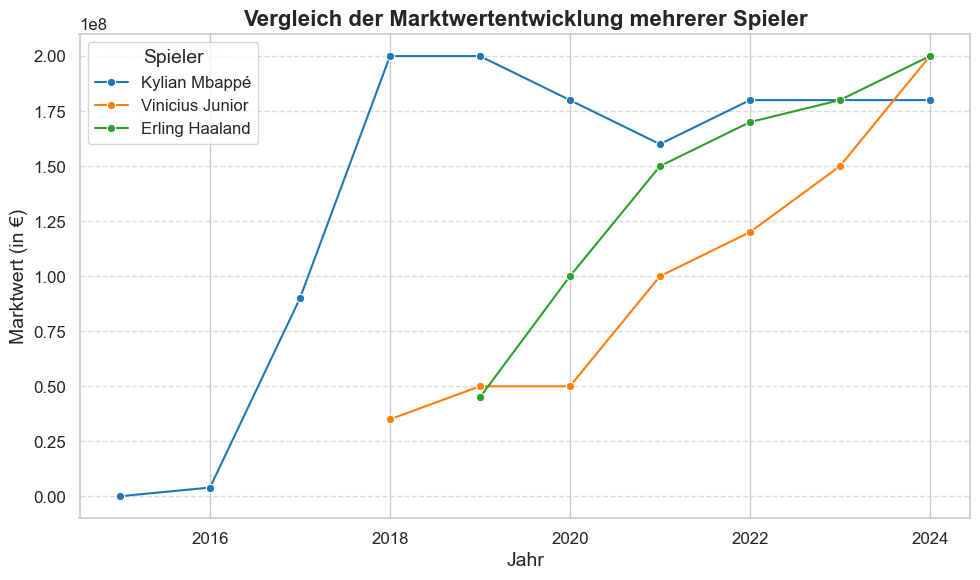

In [258]:
lineplot_data = combined_data_hist[combined_data_hist['player_id'].isin(["418560", "371998", "342229"])]

plt.figure(figsize=(10, 6))

sns.lineplot(
    data=lineplot_data,
    x='year',
    y='historical_to_date__market_value',
    hue='name',
    marker="o",
    palette="tab10"
)

plt.title("Vergleich der Marktwertentwicklung mehrerer Spieler", fontsize=16, weight='bold')
plt.xlabel("Jahr", fontsize=14)
plt.ylabel("Marktwert (in €)", fontsize=14)
plt.legend(title="Spieler", fontsize=12, title_fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


Das Diagramm zeigt die Marktwertentwicklung dreier Spieler – Kylian Mbappé, Erling Haaland und Vinícius Júnior – über die Jahre. Alle Spieler zeigen ein konstantes Wachstum ihres Marktwerts, was ihre steigende Leistung und Attraktivität auf dem Transfermarkt widerspiegelt. Besonders Kylian Mbappé sticht hervor: Ab 2017 steigt sein Marktwert rapide an und stabilisiert sich bei ca. 200 Millionen Euro, was seine Stellung als einer der teuersten Spieler der Welt unterstreicht. Im Gegensatz dazu zeigt Erling Haaland erst ab 2019 einen signifikanten Anstieg seines Marktwerts, der mit seinem internationalen Durchbruch korreliert. Vinícius Júnior weist eine stetige, aber weniger drastische Entwicklung auf, was auf eine kontinuierliche Leistungssteigerung hindeutet. Insgesamt spiegelt das Diagramm unterschiedliche Karriereverläufe wider, wobei bei Mbappé eine Stabilisierung und bei Haaland ein starkes Wachstum erkennbar ist.

In [ ]:
fig = px.scatter(
    lineplot_data,
    x='year',
    y='historical_to_date__market_value',
    color='name',
    size='goals_per_game',  # Punktgröße basiert auf Toren pro Spiel
    hover_data={
        'name': True,
        'goals_per_game': True,
        'assists_per_game': True,
        'height_in_cm': True,
        'year': True,
        'age': True,
    },
    title="Vergleich der Marktwertentwicklung mit Toren",
    labels={
        'name': "Name",
        'year': 'Jahr',
        'historical_to_date__market_value': 'Marktwert (in €)',
        'goals_per_game': 'Tore pro Spiel',
        'assists_per_game':'Assist pro Spiel',
        'age': "Alter",
        'height_in_cm': "Größe in cm"
    }
)

fig.update_traces(mode='lines+markers')  # Linien und Marker
fig.update_layout(
    legend_title="Spieler",
    hovermode="x unified",
)

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")


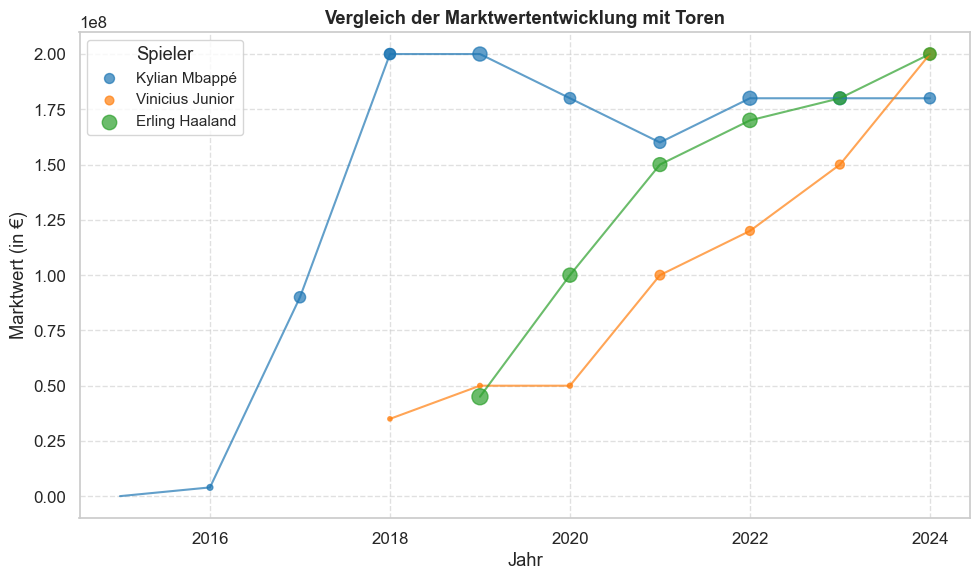

In [259]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))

lineplot_data_players = lineplot_data['name'].unique()
colors = sns.color_palette("tab10", len(lineplot_data_players))

for i, player in enumerate(lineplot_data_players):
    player_data = lineplot_data[lineplot_data['name'] == player]
    plt.scatter(
        player_data['year'], 
        player_data['historical_to_date__market_value'], 
        s=player_data['goals_per_game'] * 100,  # Punktgröße basierend auf Toren pro Spiel
        color=colors[i], 
        label=player,
        alpha=0.7
    )
    plt.plot(
        player_data['year'], 
        player_data['historical_to_date__market_value'], 
        color=colors[i], 
        alpha=0.7
    )

plt.title("Vergleich der Marktwertentwicklung mit Toren", weight='bold')
plt.xlabel("Jahr")
plt.ylabel("Marktwert (in €)")
plt.legend(title="Spieler", loc="upper left", fontsize="small")
plt.grid(visible=True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


Diese Diagramm erweitert die Analyse, indem es den Marktwert mit der Anzahl der Tore pro Spiel (dargestellt durch die Kreisgrößen) verknüpft. Hier zeigt sich ein klarer Zusammenhang: Spieler mit höheren Torzahlen, wie Erling Haaland ab 2020, tendieren zu einem stark ansteigenden Marktwert. Kylian Mbappé hingegen bleibt unabhängig von seiner Torleistung auf konstant hohem Marktwert, was zeigt, dass sein Status als Starspieler und sein Werbewert eine zentrale Rolle spielen. Vinícius Júnior hat kleinere Kreise (weniger Tore pro Spiel), bleibt aber dennoch stabil im Marktwert. Besonders auffällig ist die Entwicklung Haalands: Seine Leistungssteigerung in Form vieler Tore führt zu einer entsprechenden Steigerung seines Marktwerts. Dieses Diagramm unterstreicht, wie sportliche Leistungen, insbesondere Tore, bei aufstrebenden Spielern den Marktwert beeinflussen, während bei etablierten Stars wie Mbappé andere Faktoren dominieren.

##### Analyse nach Postition

In [ ]:
avg_value = combined_data_agg.groupby("position")["current_market_value"].mean().reset_index()
avg_value = avg_value.sort_values("current_market_value", ascending=False)
fig = px.bar(avg_value, x="position", y="current_market_value",
             title="Durchschnittlicher Marktwert pro Position",
             labels={'position': 'Position', 'current_market_value': 'Marktwert (€)'},
             color="current_market_value",  
             color_continuous_scale="magma" )
fig.update_coloraxes(colorbar_title="Marktwert (€)")
#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")


/var/folders/df/9tj0fbwx73g3tg845tnm3j480000gn/T/ipykernel_79674/3417089879.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




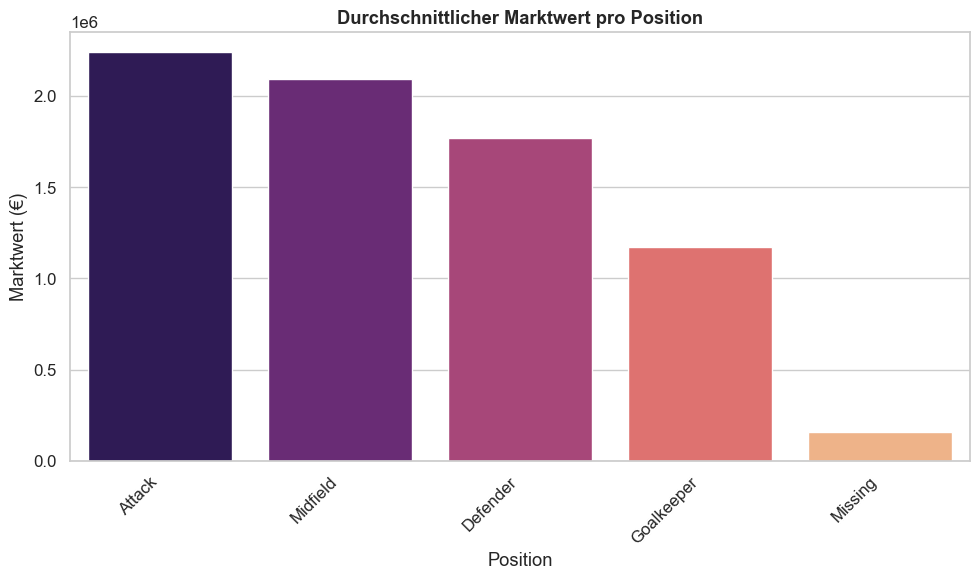

In [260]:
avg_value = combined_data_agg.groupby("position")["current_market_value"].mean().reset_index()
avg_value = avg_value.sort_values("current_market_value", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=avg_value,
    x="position",
    y="current_market_value",
    palette="magma"
)

plt.title("Durchschnittlicher Marktwert pro Position", weight='bold')
plt.xlabel("Position")
plt.ylabel("Marktwert (€)")
plt.xticks(rotation=45, ha="right")
plt.colorbar = plt.colorbar
plt.tight_layout()
plt.show()

In [ ]:
fig = px.scatter(
    combined_data_agg, 
    x='age', 
    y='current_market_value', 
    color="position",
    title="Scatterplot: Marktwert vs. Alter",
    labels={'age': 'Alter (in Jahren)', 'current_market_value': 'Marktwert (€)'}, 
    hover_data=["name", "age"] 
)

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

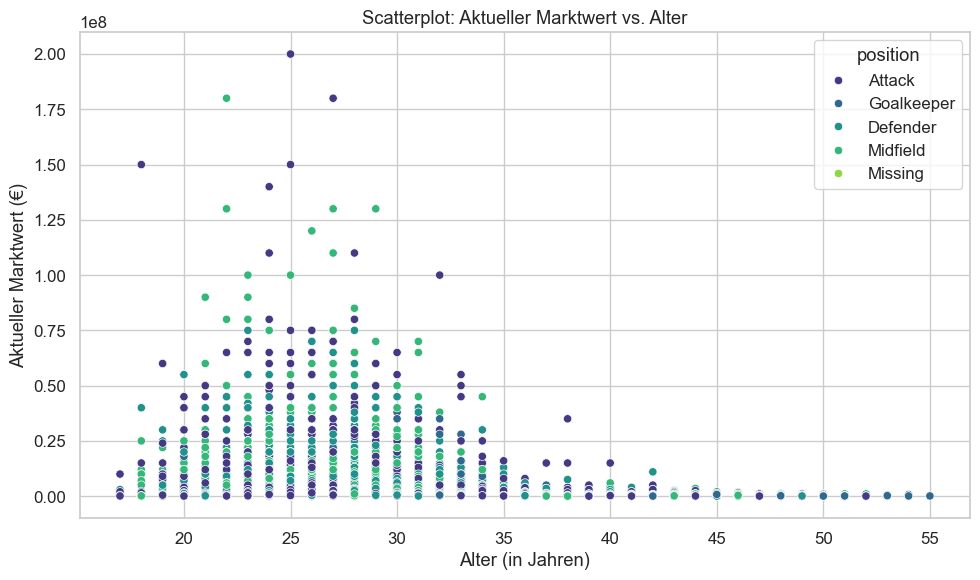

In [261]:
plt.figure(figsize=(10, 6))

# Erstelle den Scatterplot
sns.scatterplot(data=combined_data_agg, 
                x='age', 
                y='current_market_value', 
                hue="position",  
                palette='viridis') 

# Setze Achsentitel und Diagrammtitel
plt.xlabel('Alter (in Jahren)')
plt.ylabel('Aktueller Marktwert (€)')
plt.title('Scatterplot: Aktueller Marktwert vs. Alter')
plt.tight_layout()
plt.show()

In [ ]:
fig = px.scatter(combined_data_agg, x="height_in_cm", y="current_market_value", color="position",
                 hover_data=["name"], 
                 labels={'height_in_cm': 'Größe (in cm)', 'current_market_value': 'Marktwert (€)', 'name': "Name", "position": "Position"},
                 title="Alter vs. Marktwert nach Position")

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")


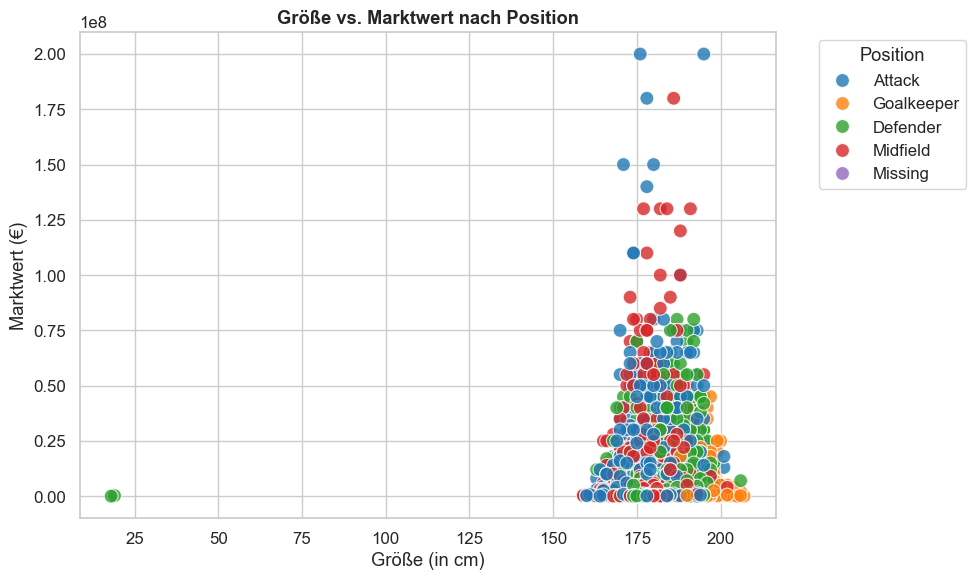

In [262]:
plt.figure(figsize=(10, 6))

scatter_plot = sns.scatterplot(
    data=combined_data_agg,
    x="height_in_cm",
    y="current_market_value",
    hue="position",
    palette="tab10",
    s=100,
    alpha=0.8
)

plt.title("Größe vs. Marktwert nach Position", weight='bold')
plt.xlabel("Größe (in cm)")
plt.ylabel("Marktwert (€)")
plt.legend(title="Position", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
fig = px.scatter(combined_data_agg, x="total_goals", y="current_market_value", color="position",
                 hover_data=["name"], 
                 labels={'total_goals': 'Gesamt Tore', 'current_market_value': 'Marktwert (€)', 'name': "Name", "position": "Position"},
                 title="Gesamt Tore vs. Marktwert nach Position")
#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

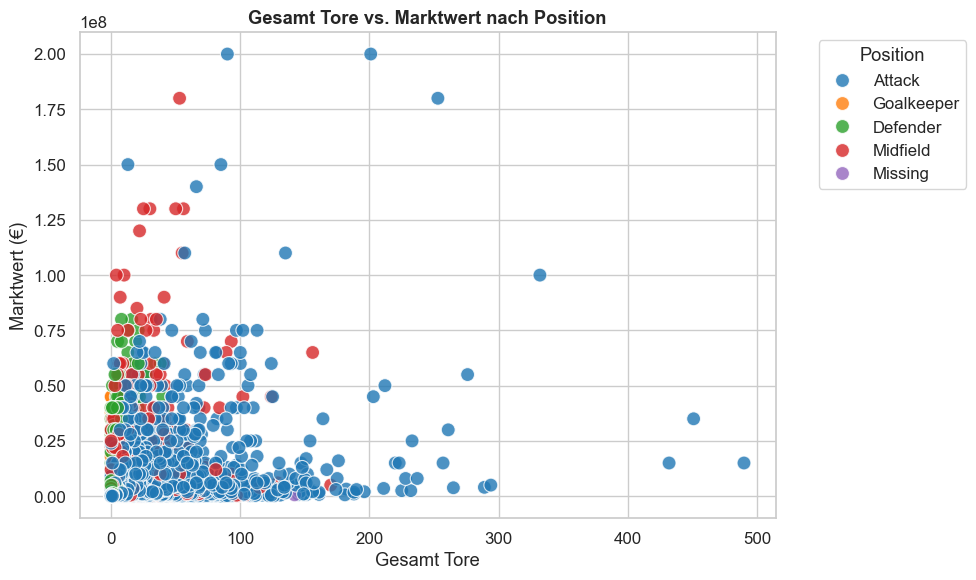

In [263]:
plt.figure(figsize=(10, 6))

scatter_plot = sns.scatterplot(
    data=combined_data_agg,
    x="total_goals",
    y="current_market_value",
    hue="position",
    palette="tab10",
    s=100,
    alpha=0.8
)

plt.title("Gesamt Tore vs. Marktwert nach Position", weight='bold')
plt.xlabel("Gesamt Tore")
plt.ylabel("Marktwert (€)")
plt.legend(title="Position", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
fig = px.scatter(combined_data_agg, x="total_goals", y="current_market_value", 
                 size="total_assists", color="position", hover_name="name",
                 labels={'total_goals': 'Gesamt Tore',"total_assists":"Gesamt Assists", 'current_market_value': 'Marktwert (€)', 'name': "Name", "position": "Position"},
                 title="Marktwert vs. Tore (Größe: Assists)")
#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")


In [ ]:

fig_data = combined_data_hist.groupby(['year', 'position'])['historical_to_date__market_value'].mean().reset_index()


fig = px.line(fig_data, x='year', y='historical_to_date__market_value', color='position',
              title='Entwicklung des durchschnittlichen Marktwerts nach Position',
              labels={'year': 'Datum', 
                      'historical_to_date__market_value': 'Durchschnittlicher Marktwert',
                      'position': 'Position'})


fig.update_layout(legend_title_text='Position')
fig.update_xaxes(title_text='Datum')
fig.update_yaxes(title_text='Durchschnittlicher Marktwert (€)')
fig.update_layout(
    hovermode="x unified"
)

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

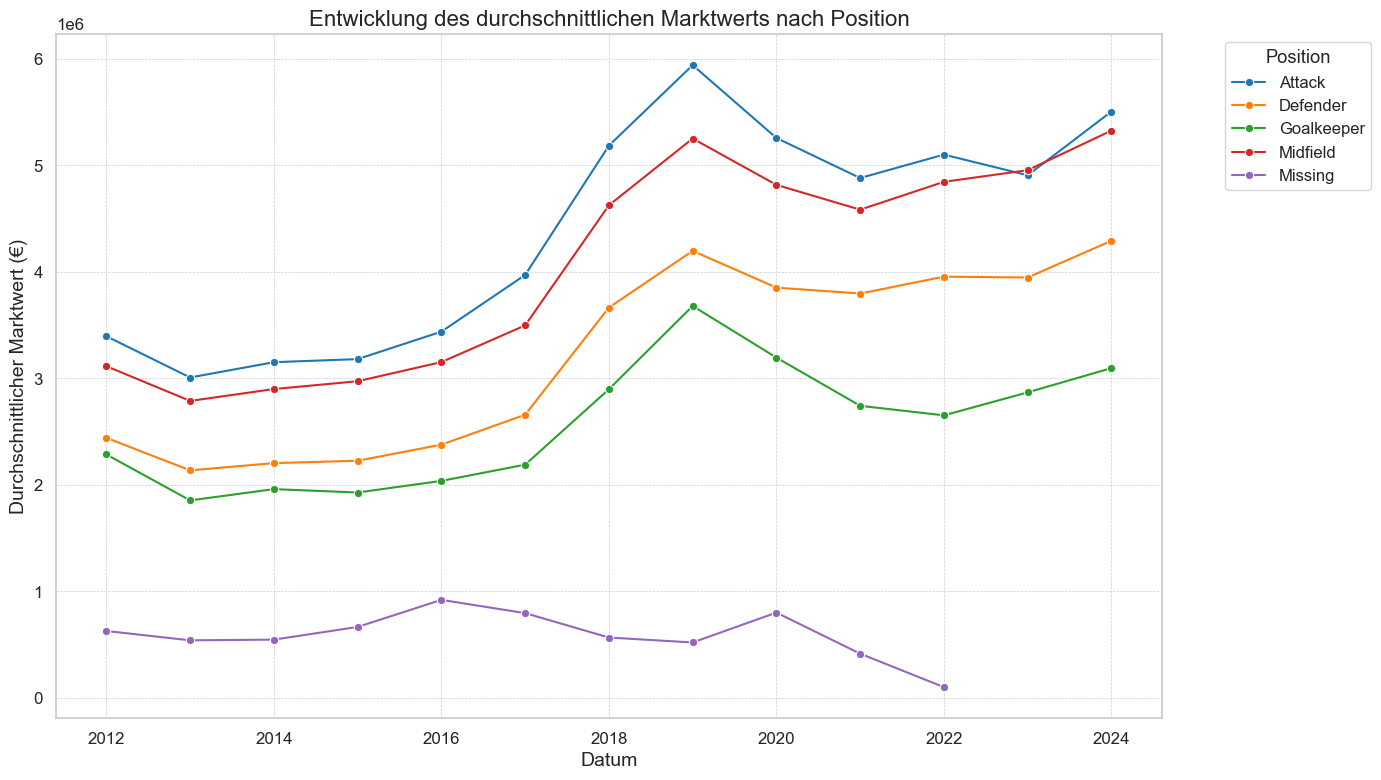

In [265]:
fig_data = combined_data_hist.groupby(['year', 'position'])['historical_to_date__market_value'].mean().reset_index()

plt.figure(figsize=(14, 8))

sns.lineplot(
    data=fig_data,
    x='year',
    y='historical_to_date__market_value',
    hue='position',
    palette='tab10',
    marker="o"
)

plt.title('Entwicklung des durchschnittlichen Marktwerts nach Position', fontsize=16)
plt.xlabel('Datum', fontsize=14)
plt.ylabel('Durchschnittlicher Marktwert (€)', fontsize=14)
plt.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [ ]:
goalkeepers = combined_data_hist[combined_data_hist['position'] == 'Goalkeeper']

fig = px.scatter(goalkeepers, 
                 x='height_in_cm', 
                 y='current_market_value',
                 hover_data=['name', 'age'],
                 labels={'current_market_value': 'Marktwert (€)', "age":"Alter", 'name': "Name", "position": "Position", 'height_in_cm': 'Größe (in cm)'},
                 title='Torwart: Größe vs. Marktwert')

fig.update_layout(
    xaxis_title='Größe (cm)',
    yaxis_title='Marktwert (€)'
)

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

/var/folders/df/9tj0fbwx73g3tg845tnm3j480000gn/T/ipykernel_79674/2928828744.py:4: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.



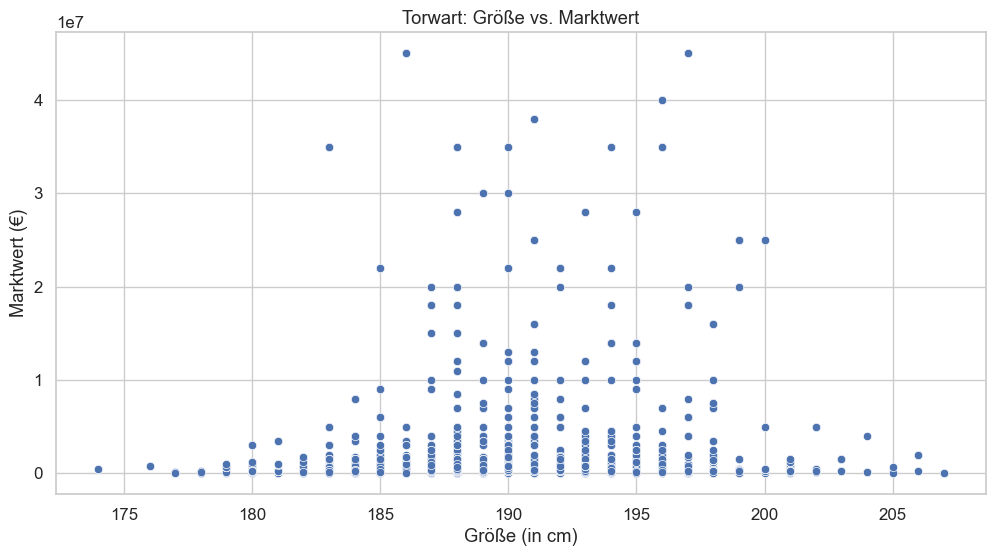

In [266]:
goalkeepers = combined_data_hist[combined_data_hist['position'] == 'Goalkeeper']

plt.figure(figsize=(12, 6))
sns.scatterplot(data=goalkeepers, 
                x='height_in_cm', 
                y='current_market_value', 
                #hue='age', 
                #style='age', 
                palette='viridis', 
                legend=None)

plt.xlabel('Größe (in cm)')
plt.ylabel('Marktwert (€)')
plt.title('Torwart: Größe vs. Marktwert')

plt.show()

In [ ]:
defenders = combined_data_hist[combined_data_hist['sub_position'].isin(['Centre-Back', 'Left-Back', 'Right-Back'])]

fig = px.scatter(defenders, 
                 x='height_in_cm', 
                 y='current_market_value',
                 color='sub_position',
                 hover_data=['name', 'age', 'yellow_cards_per_game'],
                 labels={'current_market_value': 'Marktwert (€)',"yellow_cards_per_game":"Gelbe Karten Pro Spiel", "sub_position":"Sub-Position", "age":"Alter", 'name': "Name", "position": "Position", 'height_in_cm': 'Größe (in cm)'},
                 title='Verteidiger: Größe vs. Marktwert')

fig.update_layout(
    xaxis_title='Größe (cm)',
    yaxis_title='Marktwert (€)',
    legend_title='Position'
)
#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

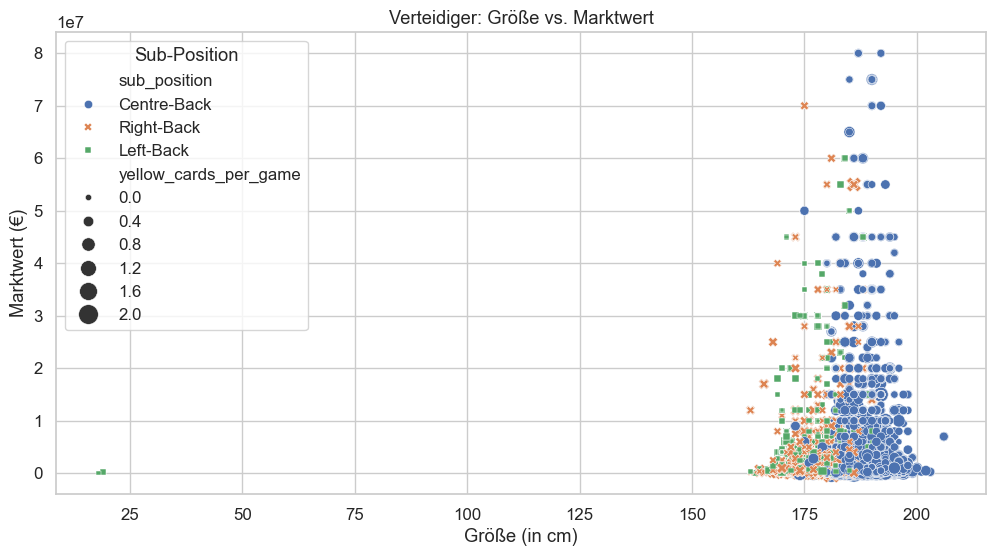

In [267]:
defenders = combined_data_hist[combined_data_hist['sub_position'].isin(['Centre-Back', 'Left-Back', 'Right-Back'])]

plt.figure(figsize=(12, 6))
sns.scatterplot(data=defenders, 
                x='height_in_cm', 
                y='current_market_value', 
                hue='sub_position', 
                palette='deep', 
                style='sub_position', 
                size='yellow_cards_per_game', 
                sizes=(20, 200))

plt.xlabel('Größe (in cm)')
plt.ylabel('Marktwert (€)')
plt.title('Verteidiger: Größe vs. Marktwert')
plt.legend(title='Sub-Position')

plt.show()

In [ ]:
midfielders = combined_data_agg[combined_data_agg['sub_position'].isin(['Defensive Midfield', 'Central Midfield', 'Attacking Midfield'])]

fig = px.scatter(midfielders, 
                 x='total_assists', 
                 y='current_market_value',
                 color='sub_position',
                 hover_data=['name', 'age', 'total_goals'],
                 labels={'current_market_value': 'Marktwert (€)',"total_goals":"Gesamte Tore", "sub_position":"Sub-Position", "age":"Alter", 'name': "Name", "total_assists": "Gesamte Assists", 'height_in_cm': 'Größe (in cm)'},
                 title='Mittelfeldspieler: Vorlagen pro Spiel vs. Marktwert')

fig.update_layout(
    xaxis_title='Vorlagen pro Spiel',
    yaxis_title='Marktwert (€)',
    legend_title='Position'
)

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

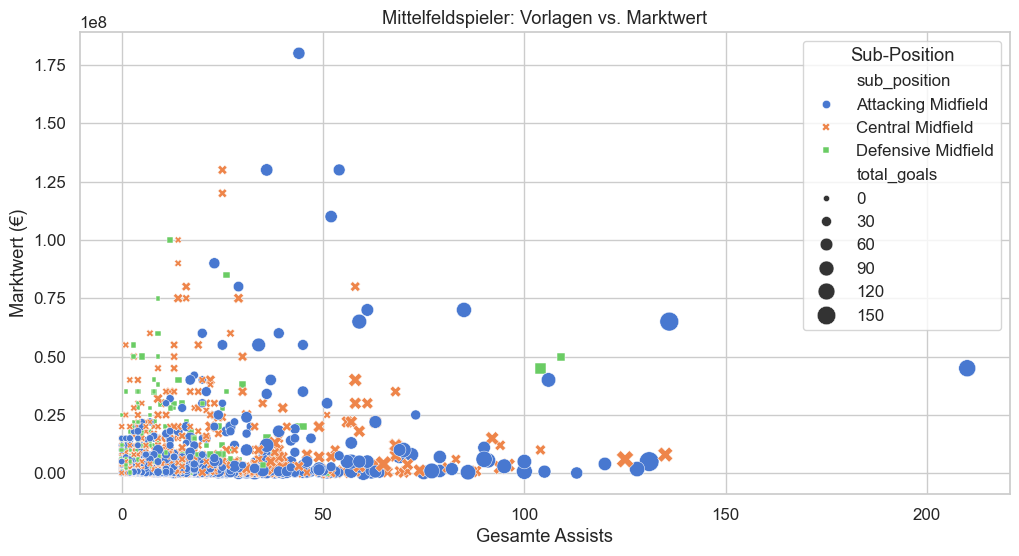

In [268]:
midfielders = combined_data_agg[combined_data_agg['sub_position'].isin(['Defensive Midfield', 'Central Midfield', 'Attacking Midfield'])]

plt.figure(figsize=(12, 6))
sns.scatterplot(data=midfielders, 
                x='total_assists', 
                y='current_market_value', 
                hue='sub_position', 
                palette='muted', 
                style='sub_position', 
                size='total_goals', 
                sizes=(20, 200))

plt.xlabel('Gesamte Assists')
plt.ylabel('Marktwert (€)')
plt.title('Mittelfeldspieler: Vorlagen vs. Marktwert')
plt.legend(title='Sub-Position')

plt.show()

In [ ]:
forwards = combined_data_agg[combined_data_agg['sub_position'].isin(['Centre-Forward', 'Second Striker', 'Left Winger', 'Right Winger'])]

fig = px.scatter(forwards, 
                 x='total_goals', 
                 y='current_market_value',
                 color='sub_position',
                 hover_data=['name', 'age', 'total_assists'],
                 labels={'current_market_value': 'Marktwert (€)',"total_goals":"Gesamte Tore", "sub_position":"Sub-Position", "age":"Alter", 'name': "Name", "total_assists": "Gesamte Assists", 'height_in_cm': 'Größe (in cm)'},
                 title='Stürmer: Tore pro Spiel vs. Marktwert')

fig.update_layout(
    xaxis_title='Tore pro Spiel',
    yaxis_title='Marktwert (€)',
    legend_title='Position'
)

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

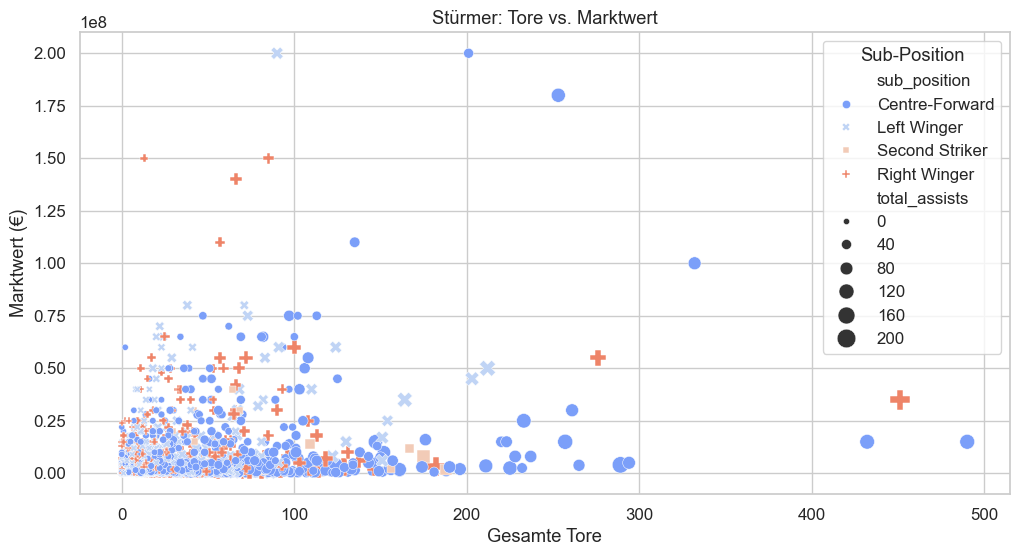

In [269]:
forwards = combined_data_agg[combined_data_agg['sub_position'].isin(['Centre-Forward', 'Second Striker', 'Left Winger', 'Right Winger'])]

plt.figure(figsize=(12, 6))
sns.scatterplot(data=forwards, 
                x='total_goals', 
                y='current_market_value', 
                hue='sub_position', 
                palette='coolwarm', 
                style='sub_position', 
                size='total_assists', 
                sizes=(20, 200))

plt.xlabel('Gesamte Tore')
plt.ylabel('Marktwert (€)')
plt.title('Stürmer: Tore vs. Marktwert')
plt.legend(title='Sub-Position')

plt.show()

In [ ]:
fig = px.box(combined_data_agg, x="foot", y="current_market_value", color="position",
             title="Marktwert nach bevorzugtem Fuß und Position",
             labels={'current_market_value': 'Marktwert (€)',"foot":"Fuß", "position":"Position"})

fig.update_layout(
    xaxis_title="Bevorzugter Fuß",
    yaxis_title="Marktwert (€)",
    legend_title="Position"
)
#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

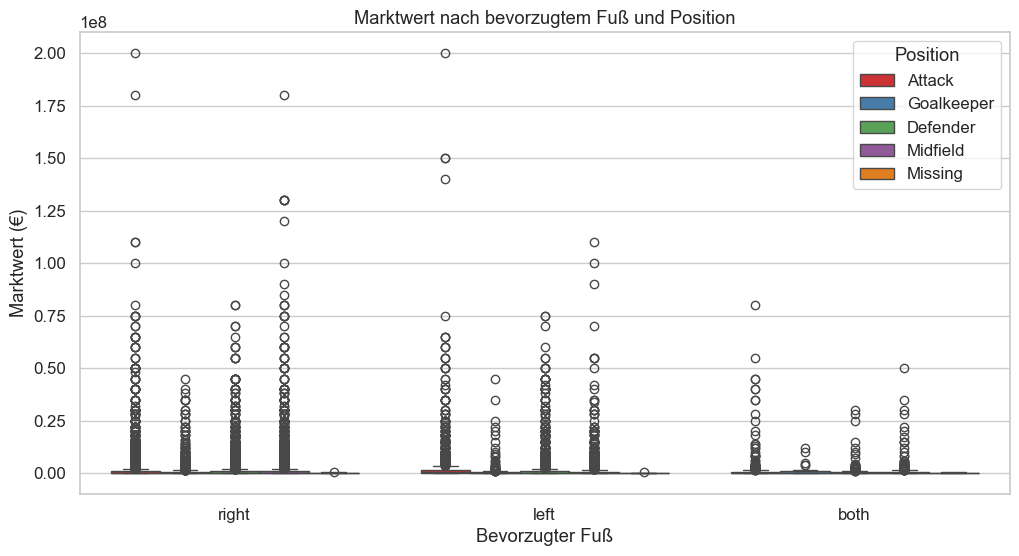

In [270]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_data_agg, 
            x='foot', 
            y='current_market_value', 
            hue='position', 
            palette='Set1') 

plt.xlabel('Bevorzugter Fuß')
plt.ylabel('Marktwert (€)')
plt.title('Marktwert nach bevorzugtem Fuß und Position')
plt.legend(title='Position')

plt.show()

In [ ]:
fig = px.box(combined_data_agg_no_outliers, x="foot", y="current_market_value", color="position",
             title="Marktwert nach bevorzugtem Fuß und Position",
             labels={'current_market_value': 'Marktwert (€)',"foot":"Fuß", "position":"Position"})

fig.update_layout(
    xaxis_title="Bevorzugter Fuß",
    yaxis_title="Marktwert (€)",
    legend_title="Position"
)

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

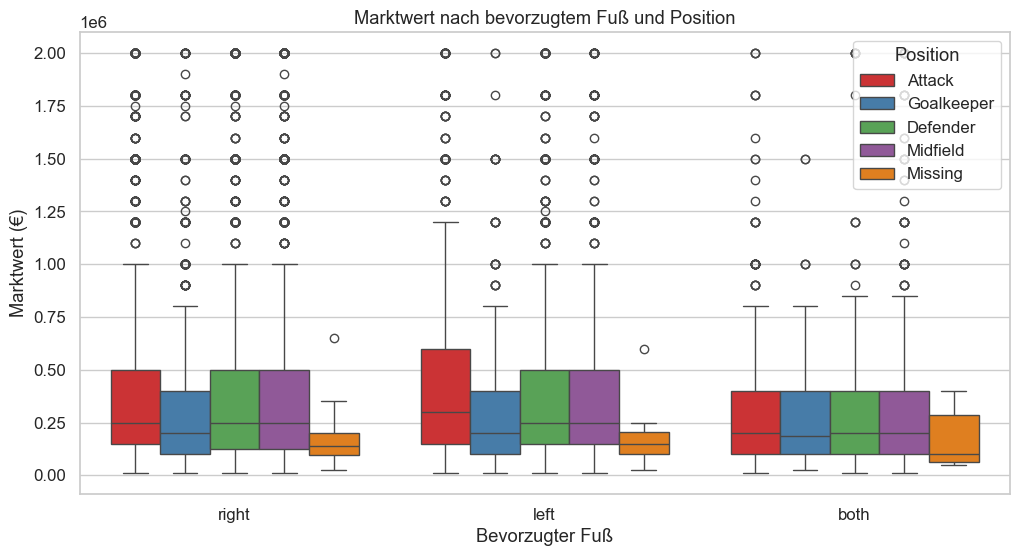

In [271]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=combined_data_agg_no_outliers, 
            x='foot', 
            y='current_market_value', 
            hue='position', 
            palette='Set1')  # Verwendung einer lebendigen Farbpalette

plt.xlabel('Bevorzugter Fuß')
plt.ylabel('Marktwert (€)')
plt.title('Marktwert nach bevorzugtem Fuß und Position')
plt.legend(title='Position')

plt.show()

In [212]:

top_5_leagues = ['GB1', 'ES1', 'FR1', 'IT1', 'L1']


combined_data_agg_top_league = combined_data_agg[(combined_data_agg["is_retired"] == False) & (combined_data_agg["league_id"].isin(top_5_leagues))]

fig = px.box(combined_data_agg_top_league, x="foot", y="current_market_value", color="position",
             facet_col="league_id",
             title="Marktwert nach bevorzugtem Fuß, Position und Liga",
             labels={'current_market_value': 'Marktwert (€)',"foot":"Fuß", "position":"Position", "league_id":"Liga"})

fig.update_layout(
    xaxis_title="Fuß",
    yaxis_title="Marktwert (€)",
    legend_title="Position"
)

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")

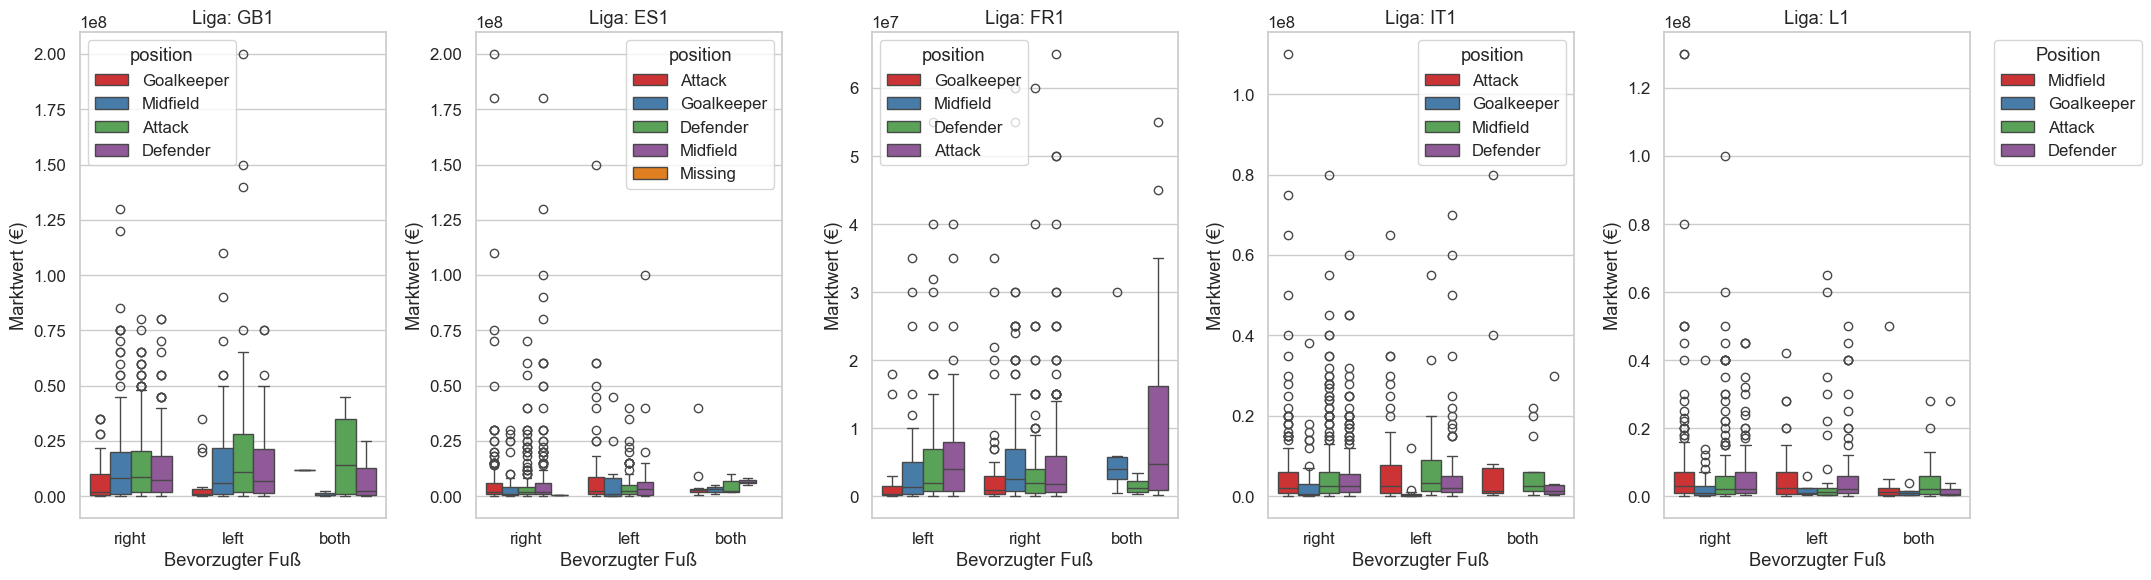

In [272]:
top_5_leagues = ['GB1', 'ES1', 'FR1', 'IT1', 'L1']
combined_data_agg_top_league = combined_data_agg[(combined_data_agg["is_retired"] == False) & 
                                                 (combined_data_agg["league_id"].isin(top_5_leagues))]

# Setze die Größe des Plots
fig, axes = plt.subplots(1, len(top_5_leagues), figsize=(20, 6))

# Erstelle für jede Liga einen Boxplot
for i, league in enumerate(top_5_leagues):
    ax = axes[i]
    sns.boxplot(data=combined_data_agg_top_league[combined_data_agg_top_league['league_id'] == league], 
                x='foot', 
                y='current_market_value', 
                hue='position', 
                palette='Set1', 
                ax=ax)
    ax.set_title(f"Liga: {league}")
    ax.set_xlabel('Bevorzugter Fuß')
    ax.set_ylabel('Marktwert (€)')

# Titel und Layout anpassen
plt.tight_layout()
plt.legend(title='Position', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [ ]:


top_5_leagues = ['GB1', 'ES1', 'FR1', 'IT1', 'L1']


#combined_data_agg_top_league = combined_data_agg[(combined_data_agg["is_retired"] == False) & (combined_data_agg["league_id"].isin(top_5_leagues))]


top_countries = combined_data_agg_top_league.groupby("country_of_citizenship").agg({
    "current_market_value": "mean",
    "player_id": "count"
}).reset_index()

min_players = 50
top_countries_filtered = top_countries[top_countries["player_id"] >= min_players]

top_10_countries = top_countries_filtered.sort_values("current_market_value", ascending=False).head(10)

fig = px.bar(top_10_countries, 
             x="country_of_citizenship", 
             y="current_market_value",
             color="player_id",  # Farbkodierung basierend auf der Anzahl der Spieler
             text="player_id",
             labels={'current_market_value': 'Marktwert (€)',"foot":"Fuß", "country_of_citizenship":"Staatsbügerschaft", "league_id":"Liga"},
             title=f"Top 10 Länder nach durchschnittlichem Marktwert (nur aktive Spieler in Top 5 Ligen, mind. {min_players} Spieler)")

fig.update_layout(
    xaxis_title="Land der Staatsbürgerschaft",
    yaxis_title="Durchschnittlicher Marktwert (€)",
    xaxis_tickangle=-45,
    coloraxis_colorbar_title="Anzahl der Spieler"
)


fig.update_traces(texttemplate='%{text} Spieler', textposition='outside')

#fig.show()
plot_title = fig.layout.title.text
safe_title = re.sub(r'[^\w\s-]', '', plot_title).replace(' ', '_')
fig.write_html(f"../references/plotly/{safe_title}.html")



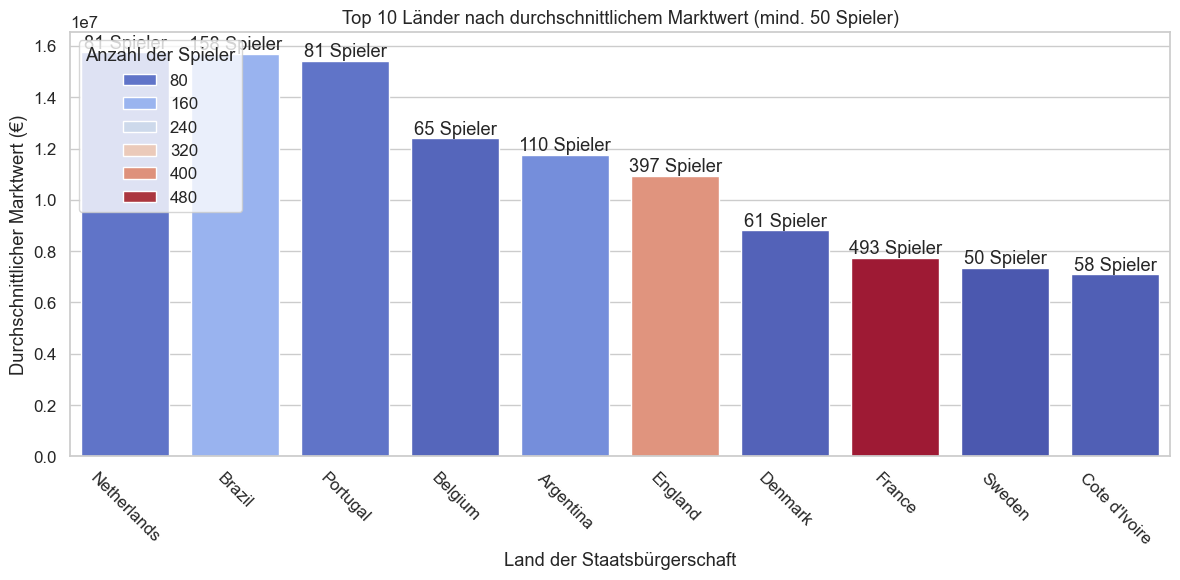

In [273]:
min_players = 50
top_countries = combined_data_agg_top_league.groupby("country_of_citizenship").agg({
    "current_market_value": "mean",
    "player_id": "count"
}).reset_index()

top_countries_filtered = top_countries[top_countries["player_id"] >= min_players]

top_10_countries = top_countries_filtered.sort_values("current_market_value", ascending=False).head(10)

# Setze die Größe des Plots
plt.figure(figsize=(12, 6))

# Erstelle das Balkendiagramm
sns.barplot(data=top_10_countries, 
            x='country_of_citizenship', 
            y='current_market_value', 
            hue='player_id',  # Farbkodierung basierend auf der Anzahl der Spieler
            palette='coolwarm')

# Füge die Anzahl der Spieler als Textbeschriftung hinzu
for i in range(len(top_10_countries)):
    plt.text(i, top_10_countries['current_market_value'].iloc[i] + 1, 
             f"{top_10_countries['player_id'].iloc[i]} Spieler", 
             ha='center', va='bottom')

# Setze Achsenbeschriftungen und Titel
plt.xlabel('Land der Staatsbürgerschaft')
plt.ylabel('Durchschnittlicher Marktwert (€)')
plt.title(f"Top 10 Länder nach durchschnittlichem Marktwert (mind. {min_players} Spieler)")

# Drehe die x-Achsenticks
plt.xticks(rotation=-45)

# Zeige den Plot an
plt.legend(title='Anzahl der Spieler', loc='upper left')
plt.tight_layout()
plt.show()

#### Relationships

Frage welche Bedeutung hat Multikorrelation hier

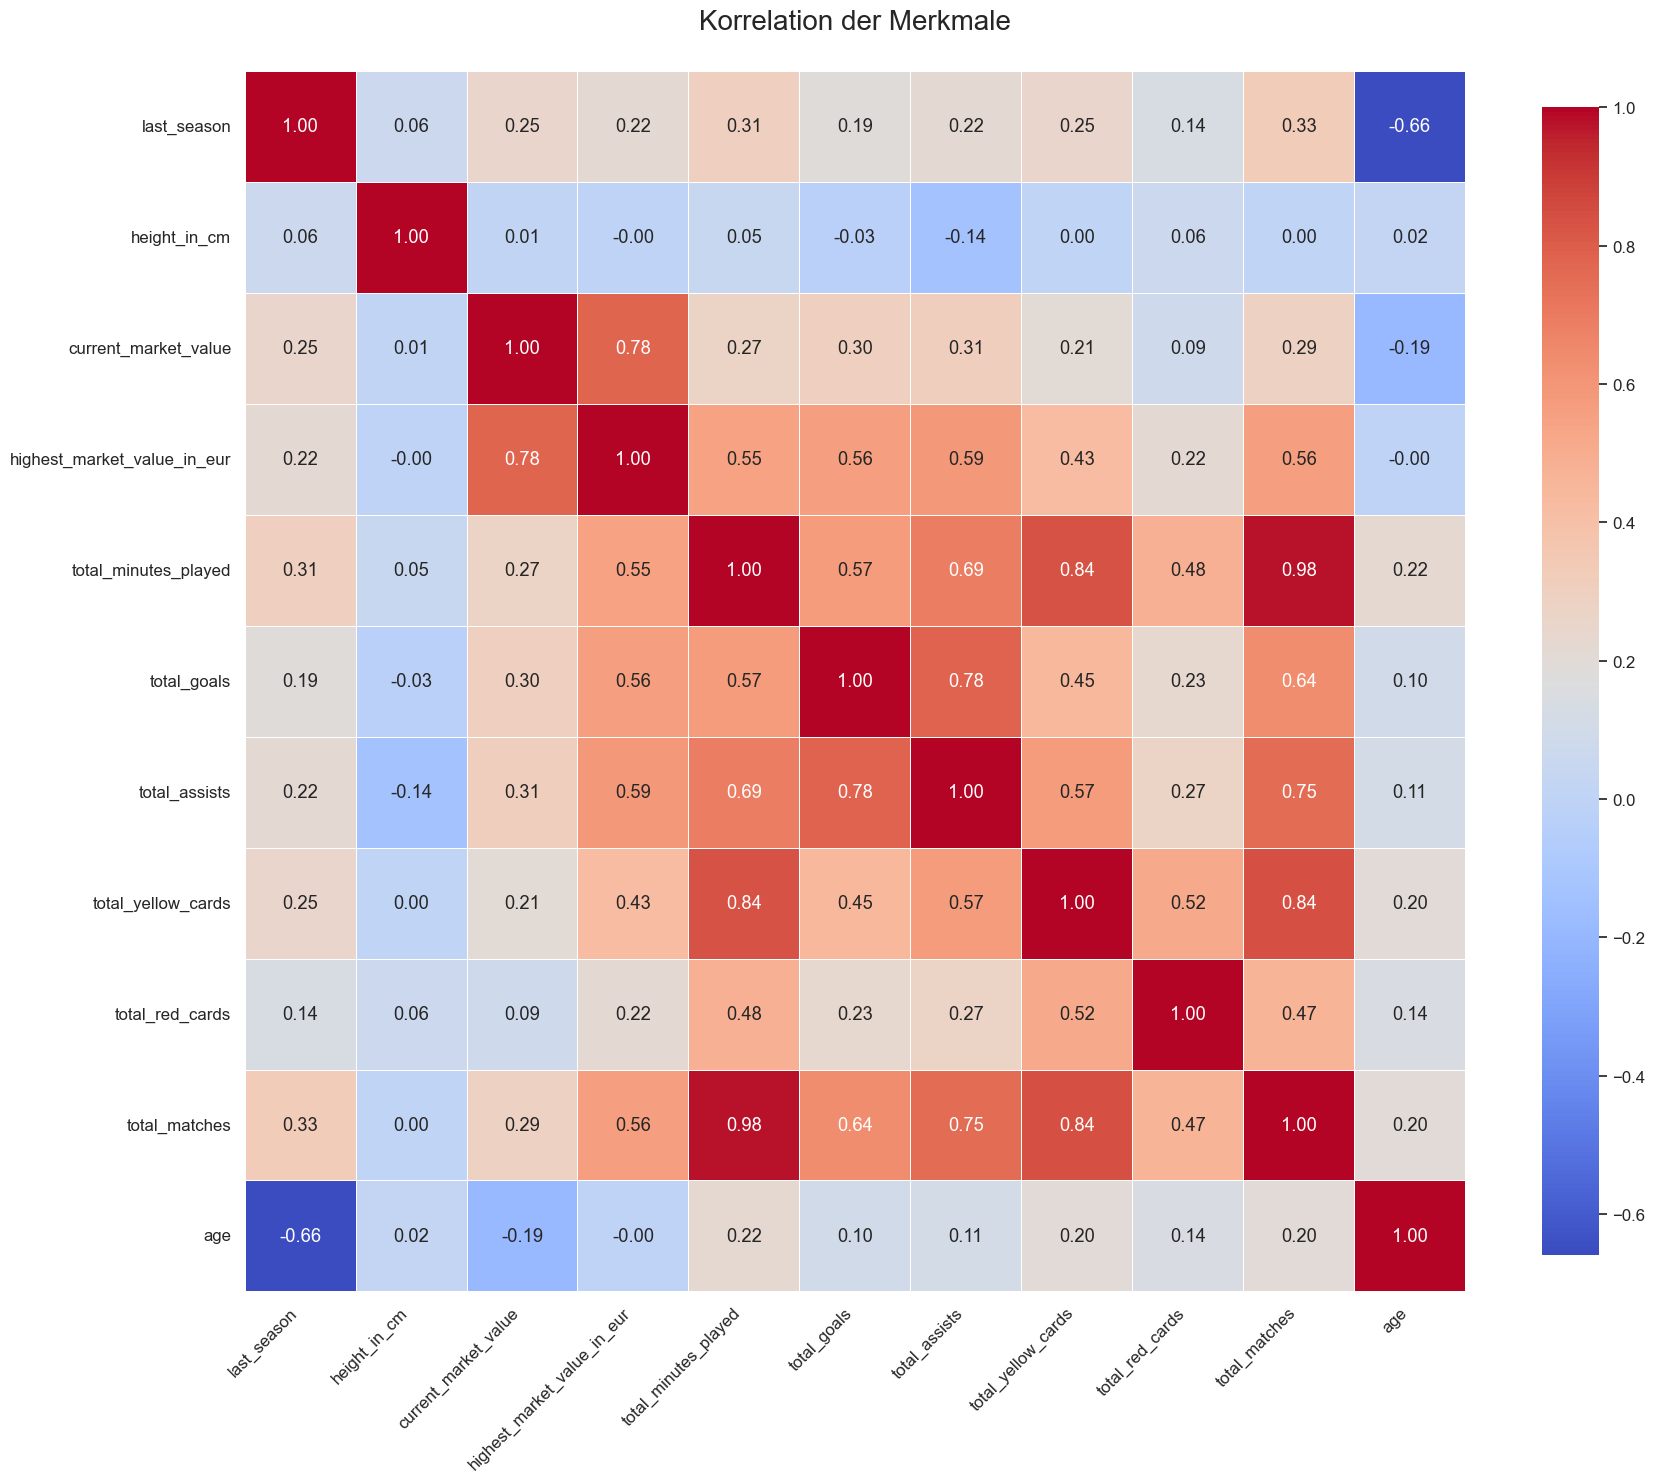

In [274]:
correlation_matrix = numeric_combined_data_agg.corr()

plt.figure(figsize=(18, 16)) 
sns.set_theme(style="white", font_scale=1.1)

sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar_kws={'shrink': 0.8},  
    linewidths=0.5, 
    square=True
)

plt.title("Korrelation der Merkmale", fontsize=20, pad=30)
plt.xticks(rotation=45, ha="right")  
plt.yticks(rotation=0)  
plt.tight_layout()  
plt.show()

Die Korrelationsmatrix zeigt die linearen Zusammenhänge zwischen den verschiedenen numerischen Merkmalen des Datensatzes, die zur Vorhersage des Marktwertes von Fußballspielern verwendet werden. Werte nahe 1 oder -1 deuten auf starke positive bzw. negative Korrelationen hin, während Werte nahe 0 auf geringe oder keine Korrelation hinweisen. Beispielsweise zeigt die Variable "highest_market_value_in_eur" mit 0.72 eine starke positive Korrelation mit dem aktuellen Marktwert ("current_market_value"), was intuitiv Sinn ergibt, da der bisher höchste Marktwert eines Spielers ein guter Indikator für dessen aktuellen Marktwert ist. Variablen wie "age" und "red_cards" zeigen eher geringe oder negative Korrelationen, was darauf schließen lässt, dass diese Faktoren weniger stark mit dem Marktwert in Zusammenhang stehen.

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Features auswählen
features = numeric_combined_data_agg

# Entfernen von fehlenden Werten
features = features.dropna()

# Konstanten hinzufügen
features_with_constant = sm.add_constant(features)

# VIF berechnen
vif_data = pd.DataFrame()
vif_data['Variable'] = features_with_constant.columns
vif_data['VIF'] = [variance_inflation_factor(features_with_constant.values, i) for i in range(features_with_constant.shape[1])]

print(vif_data)


In [ ]:
data_cleaned_agg = numeric_combined_data_agg

data_cleaned_agg = data_cleaned_agg.drop(columns=[
    #'transfer_fee',              
    #'transfer_market_value',     
    'highest_market_value_in_eur',          
    'total_minutes_played',           
    'total_matches'              
])

features = data_cleaned_agg.dropna()

features_with_constant = sm.add_constant(features)

vif_data = pd.DataFrame()
vif_data['Variable'] = features_with_constant.columns
vif_data['VIF'] = [variance_inflation_factor(features_with_constant.values, i) for i in range(features_with_constant.shape[1])]

print(vif_data)

Der Variance Inflation Factor (VIF) misst die Multikollinearität zwischen unabhängigen Variablen in einem Datensatz. Ein hoher VIF-Wert weist darauf hin, dass eine Variable stark mit anderen korreliert ist, was in Modellen wie der linearen Regression zu Verzerrungen führen kann. In diesem Schritt wurden die VIF-Werte für alle Variablen berechnet, problematische Variablen mit sehr hohen VIF-Werten identifiziert und entweder entfernt oder so transformiert, dass die Multikollinearität reduziert wurde. Ziel war es, ein Dataframe mit unabhängigen Prädiktoren zu erstellen.

In [ ]:
data_cleaned_agg

##### Historisiert

In [ ]:
numeric_combined_data_hist = combined_data_hist.select_dtypes(include=["number"])
correlation_matrix = numeric_combined_data_hist.corr()


plt.figure(figsize=(18, 16)) 
sns.set_theme(style="white", font_scale=1.1)


sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar_kws={'shrink': 0.8},  
    linewidths=0.5, 
    square=True
)


plt.title("Korrelation der Merkmale", fontsize=20, pad=30)
plt.xticks(rotation=45, ha="right")  
plt.yticks(rotation=0)  
plt.tight_layout()  
plt.show()

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


features = numeric_combined_data_hist
features = features.dropna()

features_with_constant = sm.add_constant(features)

vif_data = pd.DataFrame()
vif_data['Variable'] = features_with_constant.columns
vif_data['VIF'] = [variance_inflation_factor(features_with_constant.values, i) for i in range(features_with_constant.shape[1])]

print(vif_data)

In [ ]:
data_cleaned_hist = numeric_combined_data_hist

data_cleaned_hist = data_cleaned_hist.drop(columns=[
    #'transfer_fee',              
    'transfer_market_value',  
    #'transfer_fee_gap',   
    'highest_market_value_in_eur',
    "historical_to_date__market_value"           
])

features = data_cleaned_hist.dropna()

features_with_constant = sm.add_constant(features)

vif_data_hist = pd.DataFrame()
vif_data_hist['Variable'] = features_with_constant.columns
vif_data_hist['VIF'] = [variance_inflation_factor(features_with_constant.values, i) for i in range(features_with_constant.shape[1])]

print(vif_data_hist)


## Methodology

> REMOVE THE FOLLOWING TEXT

This section includes a brief description of your modeling process.

Explain the reasoning for the type of model you're fitting, predictor variables considered for the model.

Additionally, show how you arrived at the final model by describing the model selection process, variable transformations (if needed), assessment of conditions and diagnostics, and any other relevant considerations that were part of the model fitting process.

Es wird unterschieden zwischen: 
<!--  -->
**Aggregierte Daten**
- Mit Außreiser
- Ohne Außreiser
- Spieler der europäischen Top 5 Ligen
<!--  -->
**Historische Daten**
- Mit Außreiser
- Ohne Außreiser
- Spieler der europäischen Top 5 Ligen


#### Variable lists

Historisierte Daten für die Modellierung apassen. Für die aggregierten ist das bereits im Zuge der Analysen geschehen

In [144]:
combined_data_hist_top_league = combined_data_hist[(combined_data_hist["is_retired"] == False) & (combined_data_hist["league_id"].isin(top_5_leagues))]

In [145]:
q1 = combined_data_hist["current_market_value"].quantile(0.25)
q3 = combined_data_hist["current_market_value"].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# Filtern der Daten ohne Ausreißer
combined_data_hist_no_outliers = combined_data_hist[
    (combined_data_hist["current_market_value"] >= lower_bound) & 
    (combined_data_hist["current_market_value"] <= upper_bound)
]

In [146]:
# für historisiert combined_data_hist
features_hist = [
    "historical_to_date__market_value", 
    "year",
    #"last_season", 
    "height_in_cm",
    "country_of_citizenship",
     "foot", "position", 'goals_per_game',
       'assists_per_game', 'yellow_cards_per_game', 'red_cards_per_game',
       'minutes_played_per_game','age',
       'is_retired',
       "transfer_fee_gap",
       "transfer_fee"
]

target = "current_market_value"

In [147]:
# für aggregiert combined_data_agg
features_agg = [ 
     "height_in_cm", 
     "country_of_citizenship", 
     "foot", 
     "position", 
     'total_goals',
       'total_assists', 'total_yellow_cards', 'total_red_cards',
       'total_minutes_played',
       'age',
       'is_retired'
]

target = "current_market_value"

### Modellierung

In [148]:
def model_comparison(df, features, target):
    
    X = pd.get_dummies(df[features], drop_first=True)
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Nan mit Median füllen für Lin Reg und GB
    X_train_filled = X_train.fillna(X.median())
    X_test_filled = X_test.fillna(X.median())

    lr_model = LinearRegression()
    rf_model = RandomForestRegressor(n_estimators=120, max_depth=20, random_state=42)
    gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    hist_gb_model = HistGradientBoostingRegressor(random_state=42)
    

    lr_model.fit(X_train_filled, y_train)
    rf_model.fit(X_train, y_train)
    gb_model.fit(X_train_filled, y_train)
    hist_gb_model.fit(X_train, y_train)

    lr_predictions = lr_model.predict(X_test_filled)
    rf_predictions = rf_model.predict(X_test)
    gb_predictions = gb_model.predict(X_test_filled) 
    hist_gb_predictions = hist_gb_model.predict(X_test)

    # Metriken 
    lr_mse = mean_squared_error(y_test, lr_predictions)
    lr_r2 = r2_score(y_test, lr_predictions)
    
    rf_mse = mean_squared_error(y_test, rf_predictions)
    rf_r2 = r2_score(y_test, rf_predictions)

    gb_mse = mean_squared_error(y_test, gb_predictions)
    gb_r2 = r2_score(y_test, gb_predictions)

    hist_gb_mse = mean_squared_error(y_test, hist_gb_predictions) 
    hist_gb_r2 = r2_score(y_test, hist_gb_predictions)

    return lr_mse, lr_r2, rf_mse, rf_r2, gb_mse, gb_r2, hist_gb_mse, hist_gb_r2, y_test, lr_predictions, rf_predictions, gb_predictions,hist_gb_predictions


In [149]:
results_agg = model_comparison(combined_data_agg, features_agg, target)
results_agg_no = model_comparison(combined_data_agg_no_outliers, features_agg, target)
results_agg_top_league = model_comparison(combined_data_agg_top_league, features_agg, target)

In [150]:
results_hist = model_comparison(combined_data_hist, features_hist, target)
results_hist_no = model_comparison(combined_data_hist_no_outliers, features_hist, target)
results_hist_top_league = model_comparison(combined_data_hist_top_league, features_hist, target)

## Results

> REMOVE THE FOLLOWING TEXT

This is where you will output the final model with any relevant model fit statistics.

Describe the key results from the model.
The goal is not to interpret every single variable in the model but rather to show that you are proficient in using the model output to address the research questions, using the interpretations to support your conclusions.

Focus on the variables that help you answer the research question and that provide relevant context for the reader.


### Evaluation on test set

In [ ]:
print("=== Modellvergleich Aggregiert===")
print(f"{'Modell':<50} {'MSE':<25} {'R²':<10}")
print("="*85)
print(f"{'Linear Regression':<50} {results_agg[0]:<23.1f} {results_agg[1]:<10.4f}")
print(f"{'Linear Regression ohne Außreiser':<50} {results_agg_no[0]:<23.1f} {results_agg_no[1]:<10.4f}")
print(f"{'Linear Regression Top Spieler':<50} {results_agg_top_league[0]:<23.1f} {results_agg_top_league[1]:<10.4f}")
print()
print(f"{'Random Forest':<50} {results_agg[2]:<23.1f} {results_agg[3]:<10.4f}")
print(f"{'Random Forest ohne Außreiser':<50} {results_agg_no[2]:<23.1f} {results_agg_no[3]:<10.4f}")
print(f"{'Random Forest Top Spieler':<50} {results_agg_top_league[2]:<23.1f} {results_agg_top_league[3]:<10.4f}")
print()
print(f"{'Gradient Boosting':<50} {results_agg[4]:<23.1f} {results_agg[5]:<10.4f}")
print(f"{'Gradient Boosting ohne Außreiser':<50} {results_agg_no[4]:<23.1f} {results_agg_no[5]:<10.4f}")
print(f"{'Gradient Boosting Top Spieler':<50} {results_agg_top_league[4]:<23.1f} {results_agg_top_league[5]:<10.4f}")
print()
print(f"{'Hist Gradient Boosting':<50} {results_agg[6]:<23.1f} {results_agg[7]:<10.4f}")
print(f"{'Hist Gradient Boosting ohne Außreiser':<50} {results_agg_no[6]:<23.1f} {results_agg_no[7]:<10.4f}")
print(f"{'Hist Gradient Boosting Top Spieler':<50} {results_agg_top_league[6]:<23.1f} {results_agg_top_league[7]:<10.4f}")

In [ ]:
print("=== Modellvergleich Historisiert===")
print(f"{'Modell':<50} {'MSE':<25} {'R²':<10}")
print("="*85)
print(f"{'Linear Regression':<50} {results_hist[0]:<23.1f} {results_hist[1]:<10.4f}")
print(f"{'Linear Regression ohne Außreiser':<50} {results_hist_no[0]:<23.1f} {results_hist_no[1]:<10.4f}")
print(f"{'Linear Regression Top Spieler':<50} {results_hist_top_league[0]:<23.1f} {results_hist_top_league[1]:<10.4f}")
print()
print(f"{'Random Forest':<50} {results_hist[2]:<23.1f} {results_hist[3]:<10.4f}")
print(f"{'Random Forest ohne Außreiser':<50} {results_hist_no[2]:<23.1f} {results_hist_no[3]:<10.4f}")
print(f"{'Random Forest Top Spieler':<50} {results_hist_top_league[2]:<23.1f} {results_hist_top_league[3]:<10.4f}")
print()
print(f"{'Gradient Boosting':<50} {results_hist[4]:<23.1f} {results_hist[5]:<10.4f}")
print(f"{'Gradient Boosting ohne Außreiser':<50} {results_hist_no[4]:<23.1f} {results_hist_no[5]:<10.4f}")
print(f"{'Gradient Boosting Top Spieler':<50} {results_hist_top_league[4]:<23.1f} {results_hist_top_league[5]:<10.4f}")
print()
print(f"{'Hist Gradient Boosting':<50} {results_hist[6]:<23.1f} {results_hist[7]:<10.4f}")
print(f"{'Hist Gradient Boosting ohne Außreiser':<50} {results_hist_no[6]:<23.1f} {results_hist_no[7]:<10.4f}")
print(f"{'Hist Gradient Boosting Top Spieler':<50} {results_hist_top_league[6]:<23.1f} {results_hist_top_league[7]:<10.4f}")


Warum ist das Ergebnis so schlecht ohne Ausreißer

Der hohe MSE resultiert vor allem aus der Skalierung der Zielvariable, den Marktwerten von Fußballspielern, die teilweise extrem hoch ausfallen. Da der MSE die Fehlerwerte quadriert, wirken sich auch kleinere Abweichungen bei hohen Marktwerten überproportional stark auf das Gesamtergebnis aus. Zusätzlich tragen die große Varianz in den Daten und das Vorhandensein von Outliern – also Spielern mit außergewöhnlich hohen Marktwerten – dazu bei, dass die Fehlerspanne weiter ansteigt. Diese extremen Werte sind schwer vorherzusagen und führen zu einer Verschlechterung des MSE.

Am Wert des R2 erkennt man, dass in beiden Fällen die lineare Regression am schlechtesten die Werte approximiert. Jedoch zeigen diese Ergebnisse das es mithilfe eines Tree Modelling schwierig ist den Marktwert eines Spielers gennau vorherzusagen. Das Modell mit den besten Ergebnisse, war der Random Forest im historisierten Zusatnd.

In [ ]:
model_names = ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Hist Gradient Boosting']
mse_values = [results_agg[0], results_agg[2], results_agg[4], results_agg[6]]  # MSE-Werte
r2_values = [results_agg[1], results_agg[3], results_agg[5], results_agg[7]]   # R²-Werte

plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(model_names))

#plt.bar(index, mse_values, bar_width, label='MSE', color='blue')
plt.bar(index + bar_width, r2_values, bar_width, label='R²', color='blue')

plt.xlabel('Modelle')
plt.ylabel('Werte')
plt.title('Modellvergleich: MSE und R²')
plt.xticks(index + bar_width / 2, model_names)
plt.legend()
plt.tight_layout()
plt.show()

Diese Grafik zeigt, dass im Durchschnitt der Hist Gradient Boosing über alle Modelle hinweg die besten Ergebnissse erzielt hat. 

In [ ]:
residuals = results_agg_no[8] - results_agg_no[9] #y_test - lr_predictions

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title("Verteilung der Residuen – Aggregiert Linear Regression Ohne Außreiser")
plt.xlabel("Residuum")
plt.ylabel("Häufigkeit")
plt.grid(True)
plt.show()

In [ ]:
residuals = results_hist_top_league[8] - results_hist_top_league[9]

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title("Verteilung der Residuen – Historisiert Linear Regression Top Ligen")
plt.xlabel("Residuum")
plt.ylabel("Häufigkeit")
plt.grid(True)
plt.show()

Die Verteilung der Residuen zeigt, wie genau ein Modell die tatsächlichen Werte vorhersagen kann. Bei der Linearen Regression ist die Fehlerverteilung zwar symmetrisch um den Wert Null, jedoch deutlich breiter, welches im Vergleich den aggregierten Daten größere Fehlerquote zuzusprechen ist, als den historisierten. Dies bedeutet, dass die Lineare Regression größere Fehler (Residuen) produziert. Insbesondere zeigt der rechte Rand der Verteilung, dass das Modell einige Vorhersagen erheblich überschätzt hat. Die Häufigkeit von Residuen nahe Null ist zwar hoch, dennoch führen die großen Fehler dazu, dass die Leistung des Modells beeinträchtigt wird. Diese breitere Streuung deutet darauf hin, dass die Lineare Regression die nichtlinearen und komplexen Zusammenhänge in den Daten nicht ausreichend abbilden kann.

In [ ]:
residuals = results_agg_top_league[8] - results_agg_top_league[10]

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title("Verteilung der Residuen – Aggregiert Random Forest Regression Top Ligen")
plt.xlabel("Residuum")
plt.ylabel("Häufigkeit")
plt.grid(True)
plt.show()

In [ ]:
residuals = results_hist[8] - results_hist[10]

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title("Verteilung der Residuen – Historisiert Random Forest Regression Top Ligen")
plt.xlabel("Residuum")
plt.ylabel("Häufigkeit")
plt.grid(True)
plt.show()

Im Vergleich dazu zeigt die Random Forest Regression eine wesentlich engere Fehlerverteilung, bei der die meisten Residuen deutlich näher an Null liegen. Dies verdeutlicht, dass die Vorhersagen des Random Forest Modells genauer sind und der Marktwert der Spieler besser approximiert wurde. Auch hier hat das historisierte Modell eine geringere Fehlerquote.

In [ ]:
residuals = results_agg[8] - results_agg[11]

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title("Verteilung der Residuen – Historisiert GBT")
plt.xlabel("Residuum")
plt.ylabel("Häufigkeit")
plt.grid(True)
plt.show()

In [ ]:
residuals = results_hist[8] - results_hist[11]

plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.title("Verteilung der Residuen – Historisiert GBT")
plt.xlabel("Residuum")
plt.ylabel("Häufigkeit")
plt.grid(True)
plt.show()

Auch der Gradient Boosting Tree weist auf eine enge Fehlerverteilung, bei der die meisten Residuen deutlich näher an Null liegen. Die Vorhersagen des Random Forest Modells und Gradient Boosting Tree wurden ähnlich gut approximiert.

## Discussion + Conclusion


Emotionen

> REMOVE THE FOLLOWING TEXT

In this section you'll include a summary of what you have learned about your research question along with statistical arguments supporting your conclusions.
In addition, discuss the limitations of your analysis and provide suggestions on ways the analysis could be improved.
Any potential issues pertaining to the reliability and validity of your data and appropriateness of the statistical analysis should also be discussed here.
Lastly, this section will include ideas for future work.